In [89]:
# Import Lib
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import tensorflow as tf 

In [90]:
#Read all the input Data

Train = pd.read_csv('train.csv')
Population = pd.read_csv('population.csv')
Road_Network = pd.read_csv('roads_network.csv')
Test = pd.read_csv('test.csv')
SampleSubmission = pd.read_csv('sample_submission.csv')

# Exploring dataset properties:

In [91]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478741 entries, 0 to 478740
Data columns (total 27 columns):
 #   Column                                       Non-Null Count   Dtype 
---  ------                                       --------------   ----- 
 0   Accident_ID                                  478741 non-null  int64 
 1   Police_Force                                 478741 non-null  int64 
 2   Number_of_Vehicles                           478741 non-null  int64 
 3   Number_of_Casualties                         478741 non-null  int64 
 4   Date                                         478741 non-null  object
 5   Day_of_Week                                  478741 non-null  int64 
 6   Time                                         478727 non-null  object
 7   Local_Authority_(District)                   478741 non-null  int64 
 8   Local_Authority_(Highway)                    478741 non-null  object
 9   1st_Road_Class                               478741 non-null  int64 
 

In [92]:
#Check Missing Value and its distribution between train and test
print(Train.columns[Train.isnull().any()])
print(Test.columns[Test.isnull().any()])

Index(['Time', 'Road_Surface_Conditions', 'Special_Conditions_at_Site'], dtype='object')
Index(['Time', 'Road_Surface_Conditions', 'Special_Conditions_at_Site'], dtype='object')


In [93]:
print(Train.isnull().sum())
print(Test.isnull().sum())

Accident_ID                                      0
Police_Force                                     0
Number_of_Vehicles                               0
Number_of_Casualties                             0
Date                                             0
Day_of_Week                                      0
Time                                            14
Local_Authority_(District)                       0
Local_Authority_(Highway)                        0
1st_Road_Class                                   0
1st_Road_Number                                  0
Road_Type                                        0
Speed_limit                                      0
2nd_Road_Class                                   0
2nd_Road_Number                                  0
Pedestrian_Crossing-Human_Control                0
Pedestrian_Crossing-Physical_Facilities          0
Light_Conditions                                 0
Weather_Conditions                               0
Road_Surface_Conditions        

# Shuffle the DataFrame

In [94]:
from sklearn.utils import shuffle
Train = shuffle(Train,random_state=SEED)
Train.reset_index(drop=True,inplace=True)

In [95]:
Train.head(2)

,Accident_ID,Police_Force,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,...,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,state,postcode,country
0,411055,6,2,3,17/01/12,6,10:30,76,W06000011,6,...,Daylight: Street light present,Fine without high winds,Dry,None,None,1,Yes,England,BN12 6HU,United Kingdom
1,508680,43,2,1,09/09/12,1,11:20,6,E08000032,5,...,Daylight: Street light present,Fine without high winds,Dry,None,None,1,Yes,England,CO2 0HR,United Kingdom


In [96]:
#Missing Value Imputation

Train['Road_Surface_Conditions'].fillna('Missing',inplace=True)
Train['Special_Conditions_at_Site'].fillna('Missing',inplace=True)

Test['Road_Surface_Conditions'].fillna('Missing',inplace=True)
Test['Special_Conditions_at_Site'].fillna('Missing',inplace=True)

print(Train.columns[Train.isnull().any()])
print(Test.columns[Test.isnull().any()])

Index(['Time'], dtype='object')
Index(['Time'], dtype='object')


# Target Distribution

<AxesSubplot:xlabel='Number_of_Casualties', ylabel='Count'>

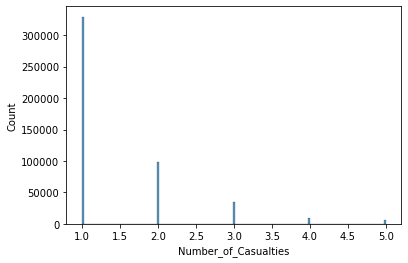

In [97]:
sns.histplot(Train['Number_of_Casualties'])

# Target is basically count's and follow Poisson distribution
# Hence after comparing baseline of objective  MSE & Poisson went ahead with modelling 
# Poisson regression based on baseline model score.

# Feature Transformation & Engineering

In [98]:
#Extract the all the alphabets from postcode prior to first number from left in 
#postcode, this represent the postal area code
Train['postcode_1'] = Train['postcode'].str.replace('\d+', '@')
Test['postcode_1'] = Test['postcode'].str.replace('\d+', '@')
############
Train[['postcode_1','postcode_2']] = Train['postcode_1'].str.split('@',1,expand=True)
Test[['postcode_1','postcode_2']] = Test['postcode_1'].str.split('@',1,expand=True)
############
Train.drop(columns='postcode_2',inplace=True)
Test.drop(columns='postcode_2',inplace=True)

C:\Users\pjp\AppData\Local\Temp/ipykernel_5780/565862636.py:3: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\pjp\AppData\Local\Temp/ipykernel_5780/565862636.py:4: FutureWarning:

The default value of regex will change from True to False in a future version.



In [99]:
#Cardinality of feature postcode & postcode_1
print(len(Train['postcode'].unique()))
print(len(Train['postcode_1'].unique()))

95625
121


In [100]:
# Check for postcode_1 value there in test and not in train
train_cols = pd.Index(Train['postcode_1'].unique())
test_cols = pd.Index(Test['postcode_1'].unique()) 
print(test_cols.difference(train_cols))

Index([], dtype='object')


In [101]:
#Transform Date feature
Train['Date'] = pd.to_datetime(Train['Date'])
Test['Date'] = pd.to_datetime(Test['Date'])

#Extract Quarter,Month & Dayofweek
Train['qtr'] = Train['Date'].dt.quarter
Train['month'] = Train['Date'].dt.month
Train['dayofweek'] = Train['Date'].dt.dayofweek
#----------------------------------------#
Test['qtr'] = Test['Date'].dt.quarter
Test['month'] = Test['Date'].dt.month
Test['dayofweek'] = Test['Date'].dt.dayofweek

In [102]:
#Transform Time feature
Train['Time'] = Train['Time'].str.replace(':','.').astype('float')
Test['Time']  = Test['Time'].str.replace(':','.').astype('float')

In [103]:
#All Categorical Columns
cat_col = Train.select_dtypes(include='object').columns

In [104]:
#Checking for value distribution in 
for col in cat_col :
    print(col)
    train_cols = pd.Index(Train[col].unique())
    test_cols = pd.Index(Test[col].unique()) 
    print(test_cols.difference(train_cols))

Local_Authority_(Highway)
Index([], dtype='object')
Road_Type
Index([], dtype='object')
Pedestrian_Crossing-Human_Control
Index([], dtype='object')
Pedestrian_Crossing-Physical_Facilities
Index([], dtype='object')
Light_Conditions
Index([], dtype='object')
Weather_Conditions
Index([], dtype='object')
Road_Surface_Conditions
Index([], dtype='object')
Special_Conditions_at_Site
Index([], dtype='object')
Carriageway_Hazards
Index([], dtype='object')
Did_Police_Officer_Attend_Scene_of_Accident
Index([], dtype='object')
state
Index([], dtype='object')
postcode
Index(['AB10 1TT', 'AB10 6LQ', 'AB11 5PA', 'AB15 4TN', 'AB15 8SP', 'AB21 7AS',
       'AB21 7PQ', 'AB21 9BE', 'AB24 5LN', 'AB25 1SJ',
       ...
       'YO61 1LR', 'YO61 3AF', 'YO62 6DG', 'YO62 6RA', 'YO7 1PY', 'YO7 4JY',
       'YO7 4NE', 'YO8 5AS', 'YO8 5RS', 'ZE2 9RJ'],
      dtype='object', length=4064)
country
Index([], dtype='object')
postcode_1
Index([], dtype='object')


In [105]:
#Rare Label encoding for postcode feature 

from feature_engine.encoding import RareLabelEncoder

encoder = RareLabelEncoder(tol=0.000003, n_categories=2, 
                           variables='postcode',
                           replace_with='Rare')

# fit the encoder
Train  = encoder.fit_transform(Train)
Test  = encoder.transform(Test)

In [106]:
train_cols = pd.Index(Train['postcode'].unique())
test_cols = pd.Index(Test['postcode'].unique()) 
print(test_cols.difference(train_cols))

Index([], dtype='object')


In [107]:
# Count Aggregate function
def agg_function(featuer,agg_featuer,Train,Test):
    agg_featuers = Train.groupby([featuer]).agg({agg_featuer: ['count']})
    agg_featuers.columns = [featuer + '_'.join(c).strip('_') for c in agg_featuers.columns]
    Train = Train.merge(agg_featuers, on = [featuer], how='left');
    Test = Test.merge(agg_featuers, on = [featuer], how='left');
    return (Train,Test)

for col in Train.select_dtypes(include='object').columns:
    Train,Test = agg_function(col,'country',Train,Test)

In [108]:
# Mean Aggregate function

def agg_function(featuer,agg_featuer,Train,Test):
    agg_featuers = Train.groupby([featuer]).agg({agg_featuer: ['mean']})
    agg_featuers.columns = [featuer + '_'.join(c).strip('_') for c in agg_featuers.columns]
    Train = Train.merge(agg_featuers, on = [featuer], how='left');
    Test = Test.merge(agg_featuers, on = [featuer], how='left');
    return (Train,Test)

Train,Test = agg_function('postcode_1','Number_of_Casualties',Train,Test)
Train,Test = agg_function('postcode_1','Local_Authority_(District)',Train,Test)
#---------------------------#
Train,Test = agg_function('Local_Authority_(Highway)','Local_Authority_(District)',Train,Test)
Train,Test = agg_function('postcode','Local_Authority_(District)',Train,Test)

In [109]:
print(Train.columns[Train.isnull().any()])
print(Test.columns[Test.isnull().any()])

Index(['Time'], dtype='object')
Index(['Time'], dtype='object')


In [110]:
Train['Time'] = Train['Time'].round(0).astype('str')
Test['Time'] = Test['Time'].round(0).astype('str')
#------------------#
Train['Time'].fillna('Missing',inplace=True)
Test['Time'].fillna('Missing',inplace=True)

In [111]:
# Count & Mean Aggregate function

def agg_function(featuer,agg_featuer,Train,Test):
    agg_featuers = Train.groupby([featuer]).agg({agg_featuer: ['count','mean']})
    agg_featuers.columns = [featuer + '_'.join(c).strip('_') for c in agg_featuers.columns]
    Train = Train.merge(agg_featuers, on = [featuer], how='left');
    Test = Test.merge(agg_featuers, on = [featuer], how='left');
    return (Train,Test)

In [112]:
Train,Test = agg_function('Time','Number_of_Casualties',Train,Test)
Train,Test = agg_function('Day_of_Week','Number_of_Casualties',Train,Test)
Train,Test = agg_function('month','Number_of_Casualties',Train,Test)
Train,Test = agg_function('qtr','Number_of_Casualties',Train,Test)
Train,Test = agg_function('1st_Road_Class','Number_of_Casualties',Train,Test)
Train,Test = agg_function('Number_of_Vehicles','Speed_limit',Train,Test)

In [113]:
print(Train.columns[Train.isnull().any()])
print(Test.columns[Test.isnull().any()])

Index([], dtype='object')
Index([], dtype='object')


In [114]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478741 entries, 0 to 478740
Data columns (total 61 columns):
 #   Column                                                    Non-Null Count   Dtype         
---  ------                                                    --------------   -----         
 0   Accident_ID                                               478741 non-null  int64         
 1   Police_Force                                              478741 non-null  int64         
 2   Number_of_Vehicles                                        478741 non-null  int64         
 3   Number_of_Casualties                                      478741 non-null  int64         
 4   Date                                                      478741 non-null  datetime64[ns]
 5   Day_of_Week                                               478741 non-null  int64         
 6   Time                                                      478741 non-null  object        
 7   Local_Authority_(District)   

In [115]:
Train.drop(columns=[],inplace=True)
Test.drop(columns=[],inplace=True)

In [116]:
# Extract Target 
Y = Train['Number_of_Casualties']

In [117]:
# Drop Unwanted columns

Train.drop(columns=['Accident_ID','Date','country','2nd_Road_Number','postcode_1',
                    'Time','Number_of_Casualties','postcode','Local_Authority_(Highway)',
                    'Road_Type','Pedestrian_Crossing-Human_Control',
                    'Pedestrian_Crossing-Physical_Facilities','Light_Conditions',
                    'Weather_Conditions','Road_Surface_Conditions',
                    'Special_Conditions_at_Site','Carriageway_Hazards',
                    'Did_Police_Officer_Attend_Scene_of_Accident','state',],inplace=True)

Test.drop(columns=['Accident_ID','Date','country','2nd_Road_Number','postcode_1',
                   'Time','Number_of_Casualties','postcode','Local_Authority_(Highway)',
                   'Road_Type','Pedestrian_Crossing-Human_Control',
                   'Pedestrian_Crossing-Physical_Facilities','Light_Conditions',
                   'Weather_Conditions','Road_Surface_Conditions',
                   'Special_Conditions_at_Site','Carriageway_Hazards',
                   'Did_Police_Officer_Attend_Scene_of_Accident','state',],inplace=True)

In [118]:
# Correlation to check Correlation among input & target feature and Histogram plots to check distribution of data in Train & Test
# & Identify possible features having different Train & Test distribution

<AxesSubplot:>

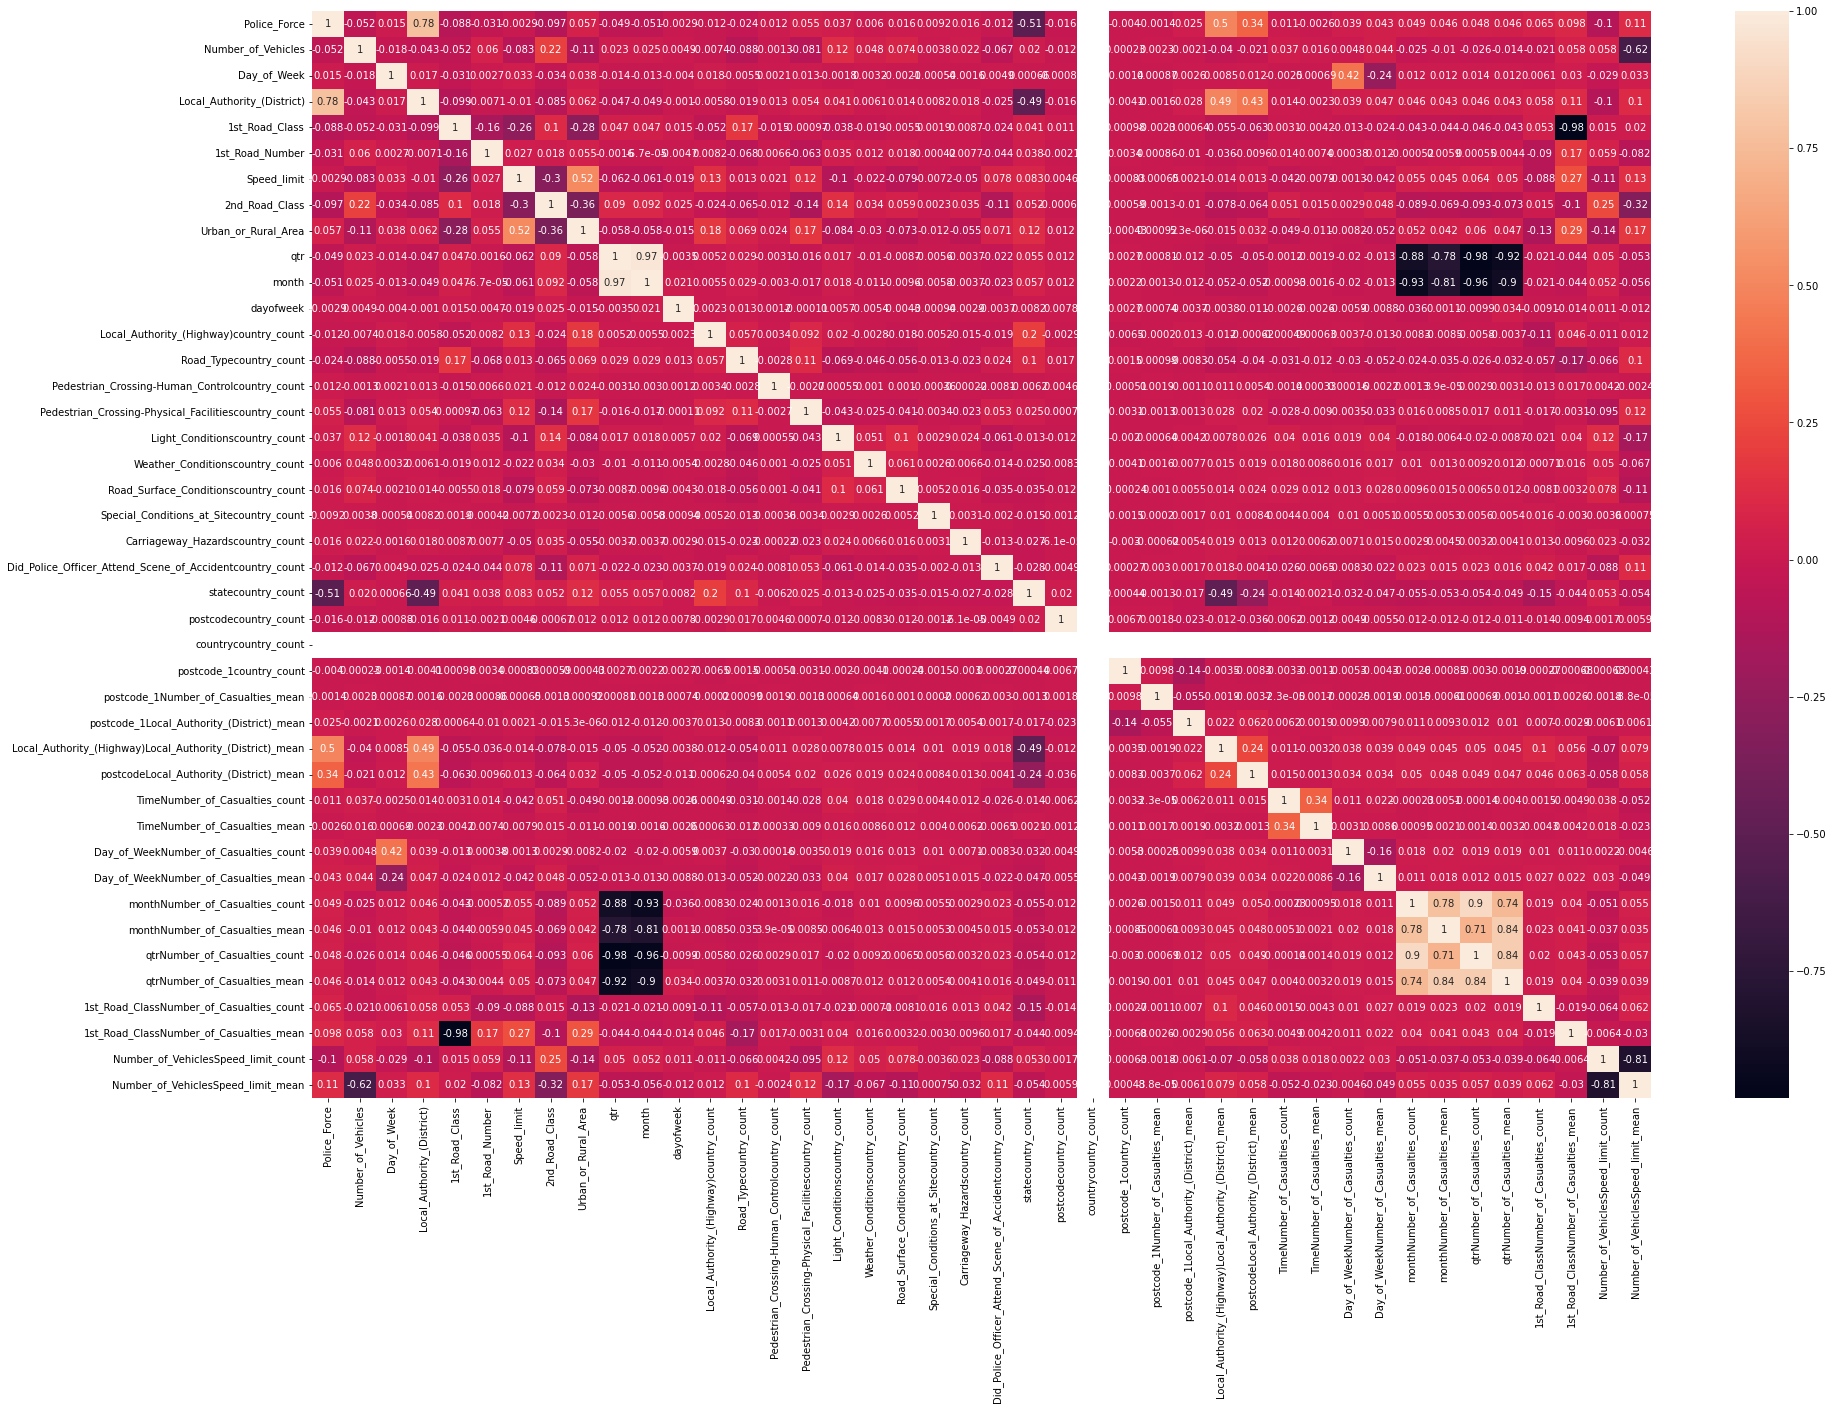

In [119]:
#PLot 
plt.figure(figsize=(30,20))
sns.heatmap(Train.corr(),annot=True)

C:\Users\pjp\AppData\Local\Temp/ipykernel_5780/1701732246.py:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



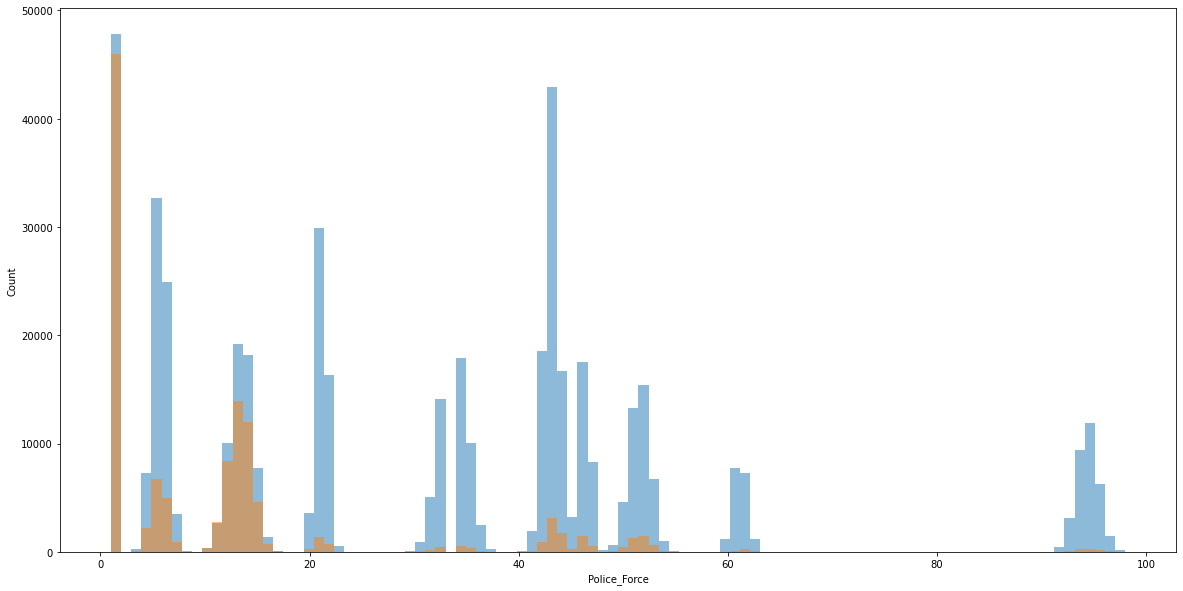

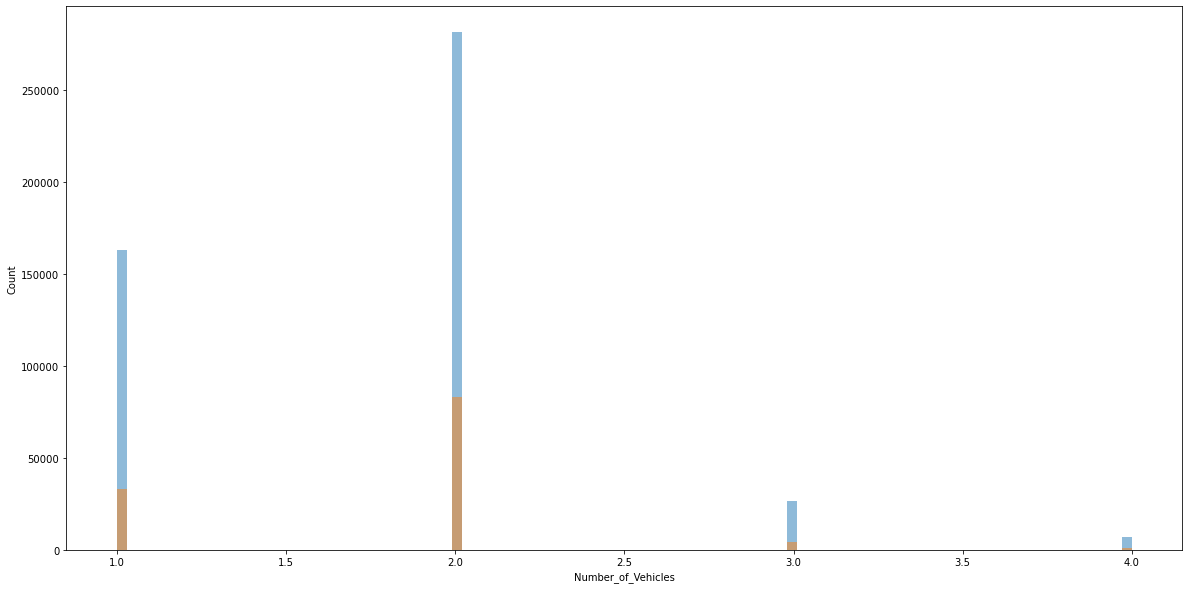

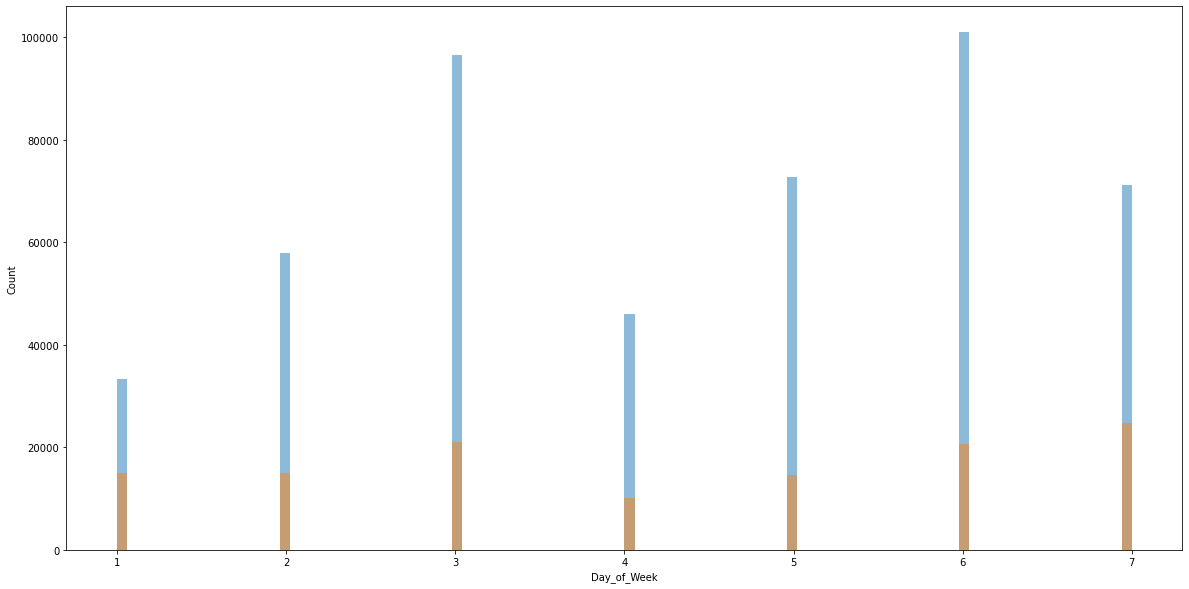

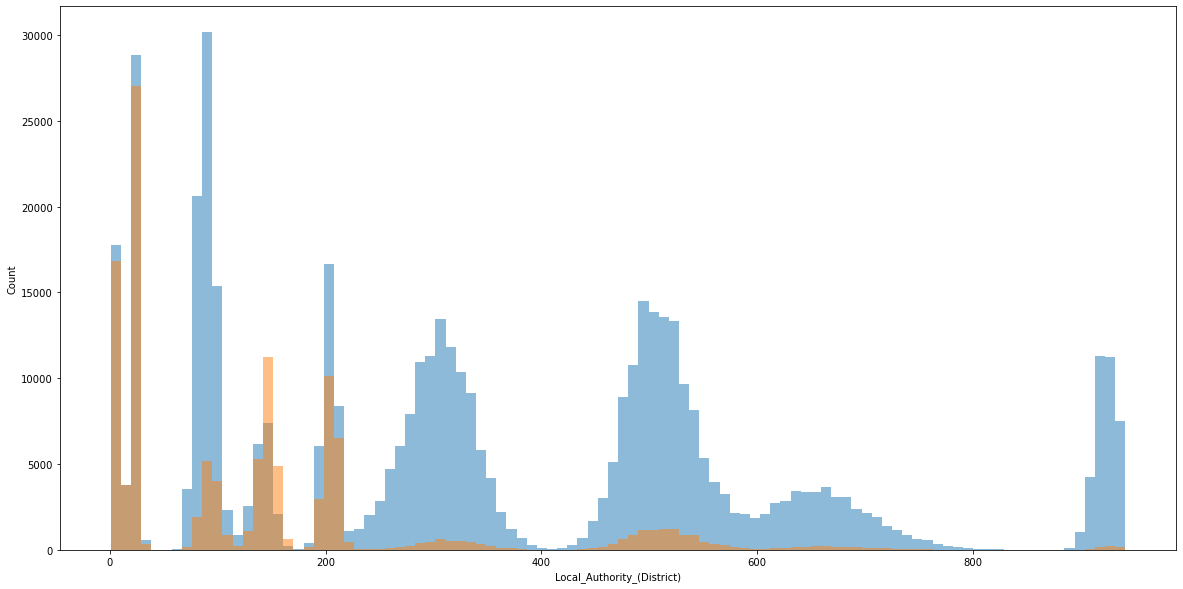

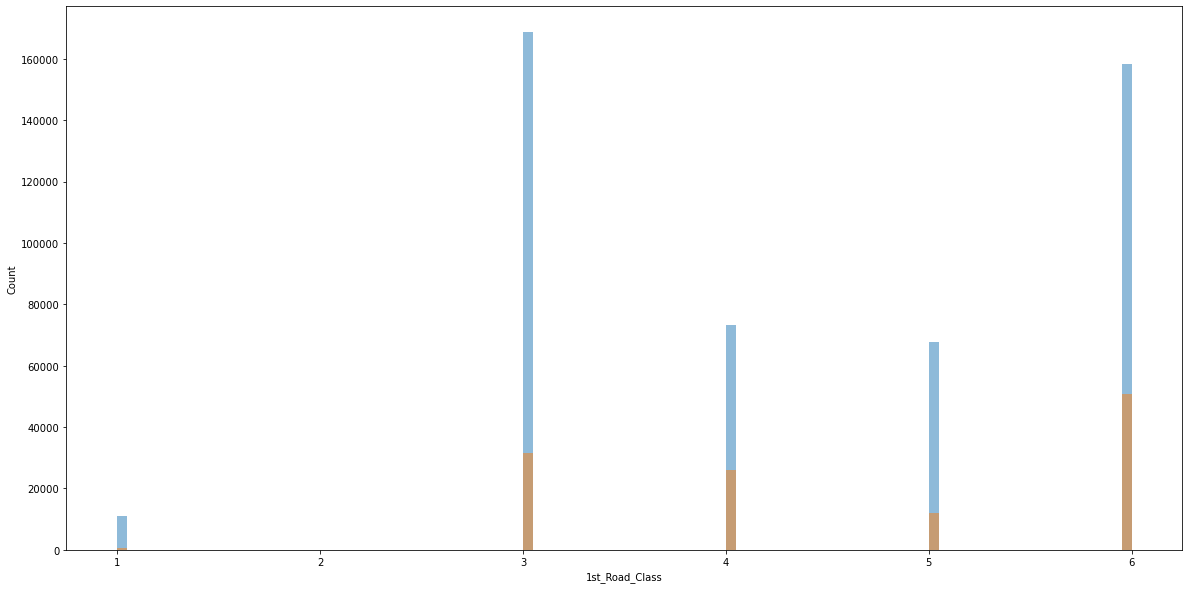

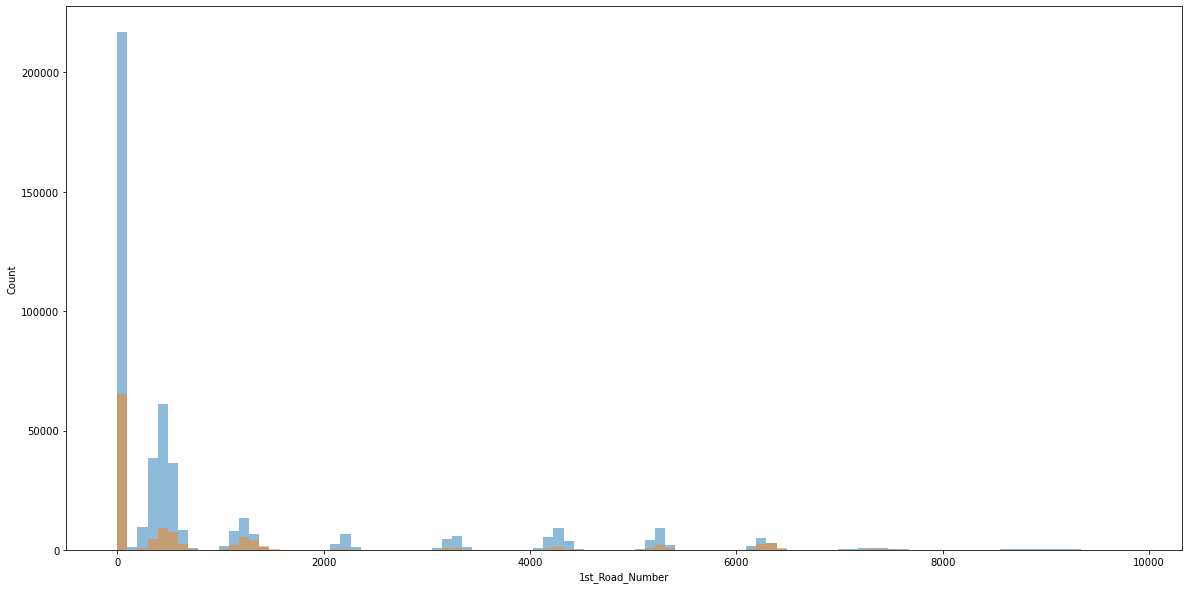

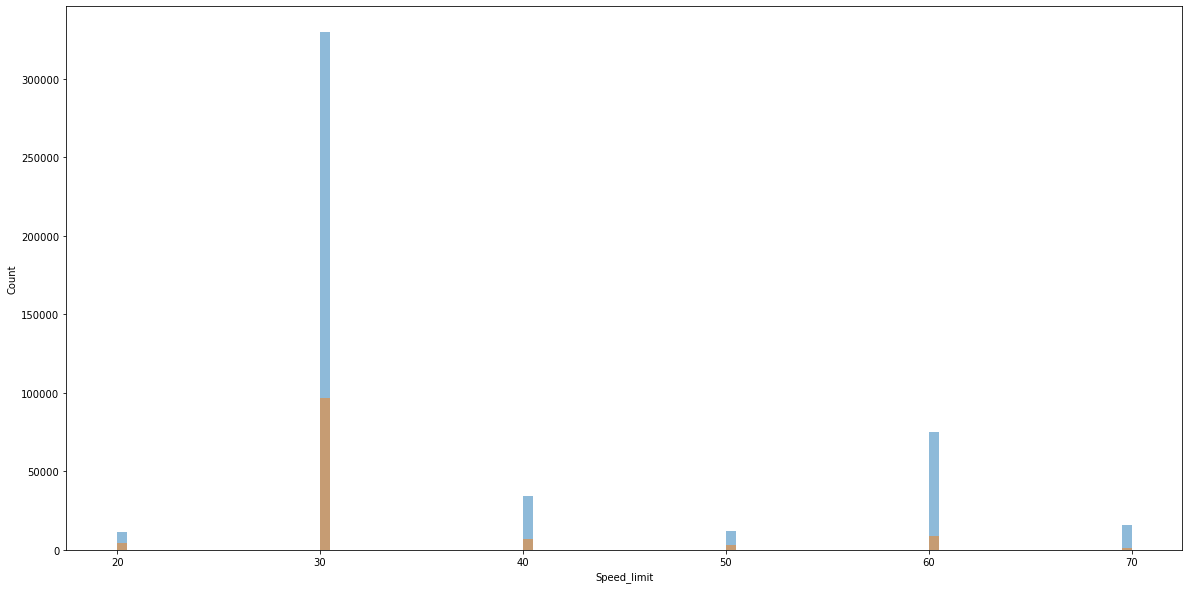

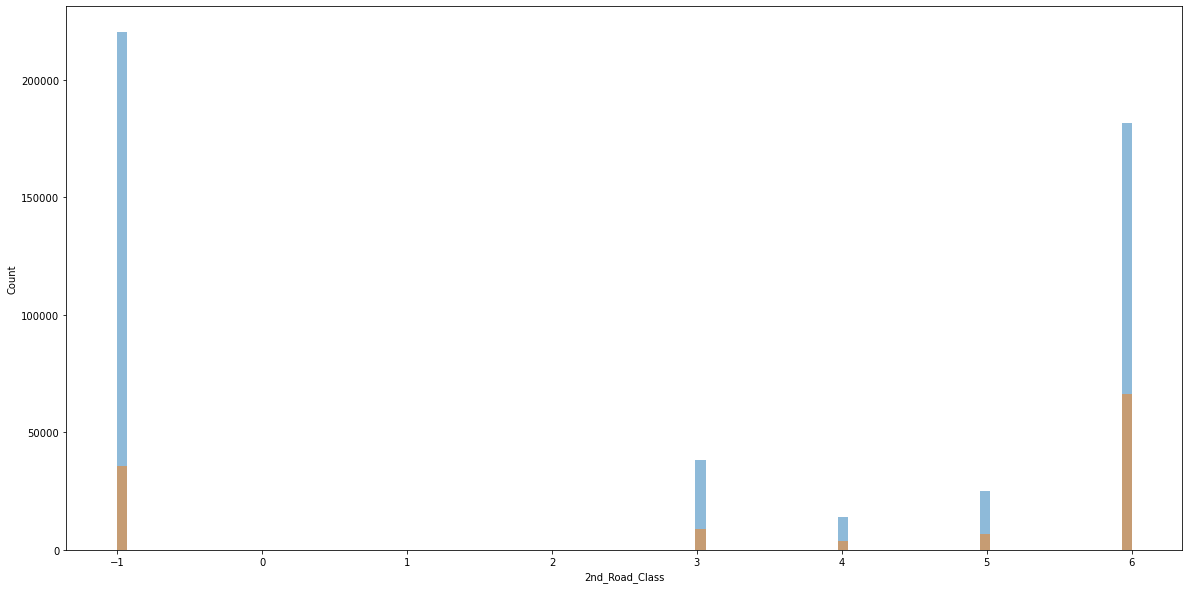

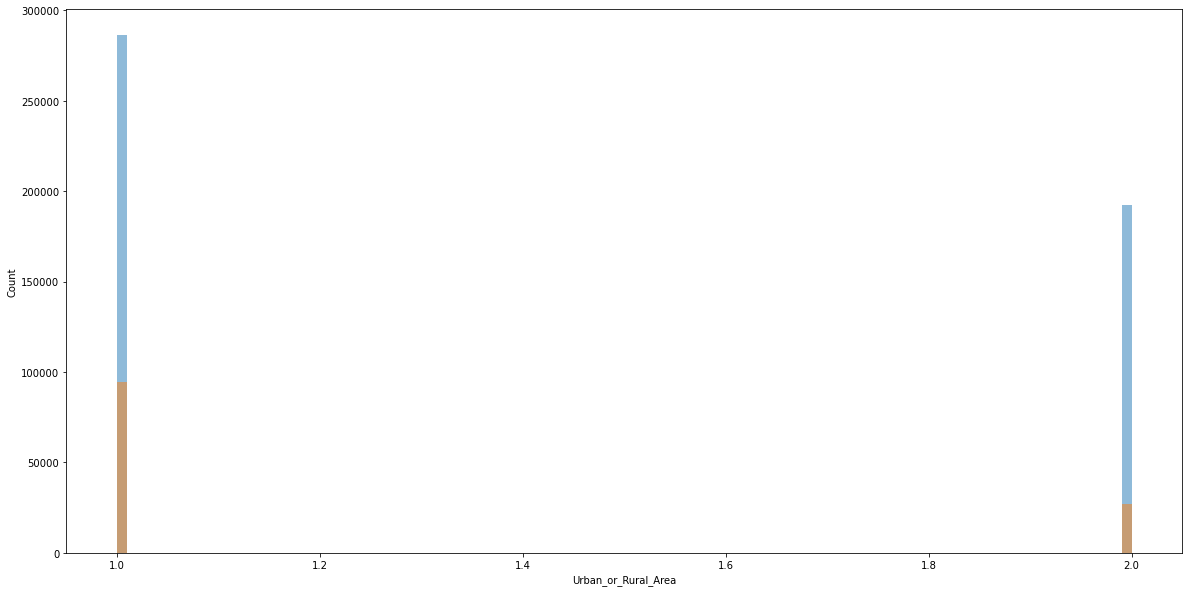

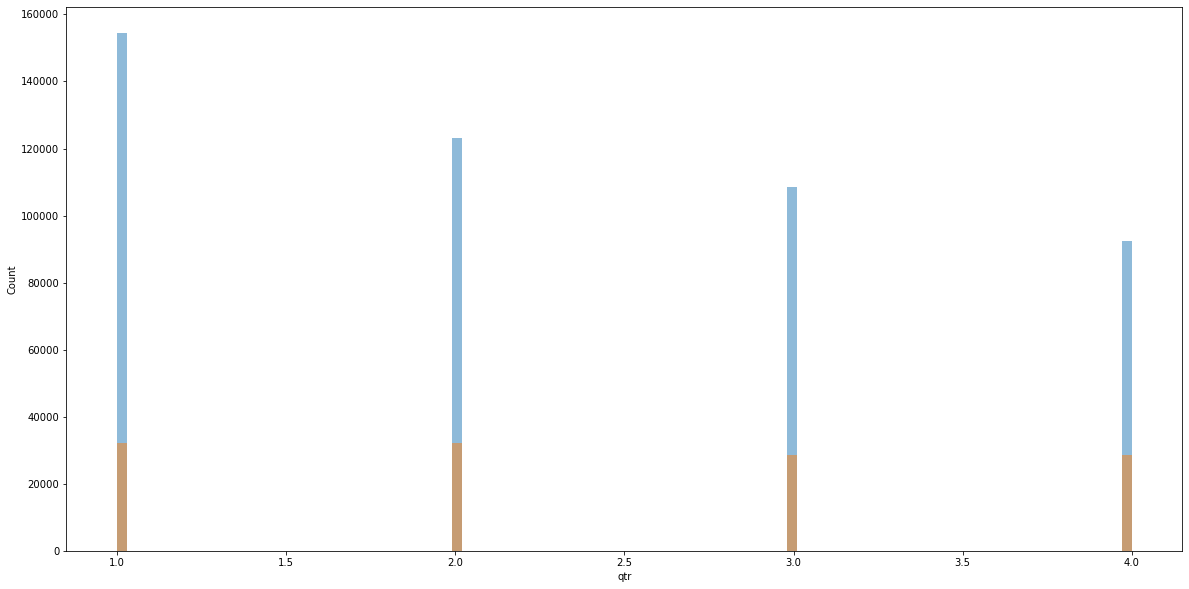

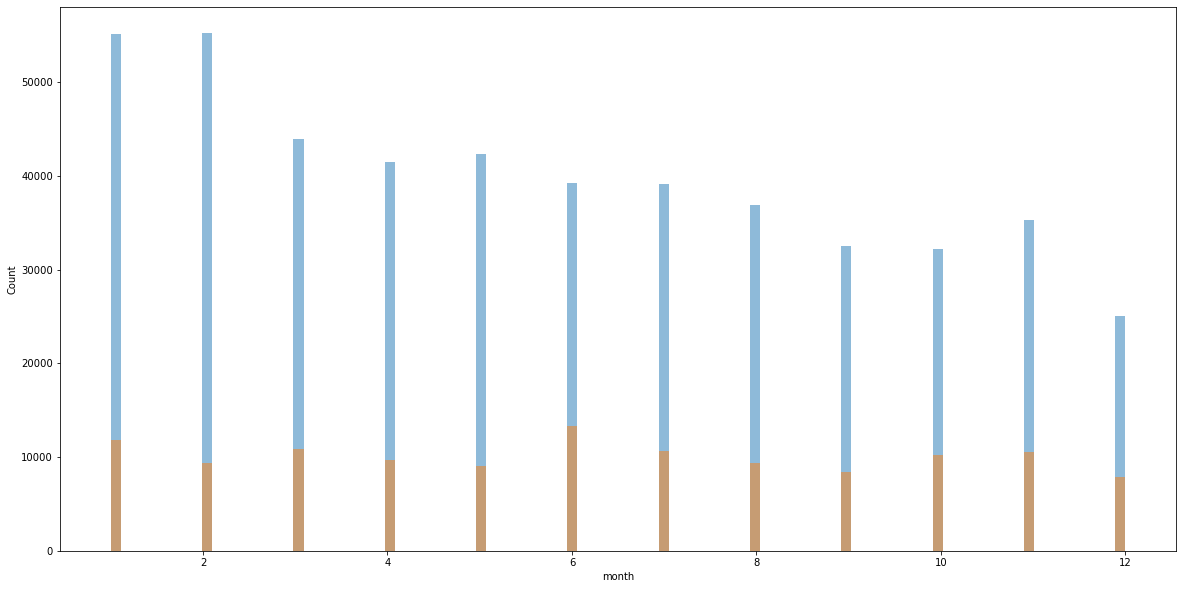

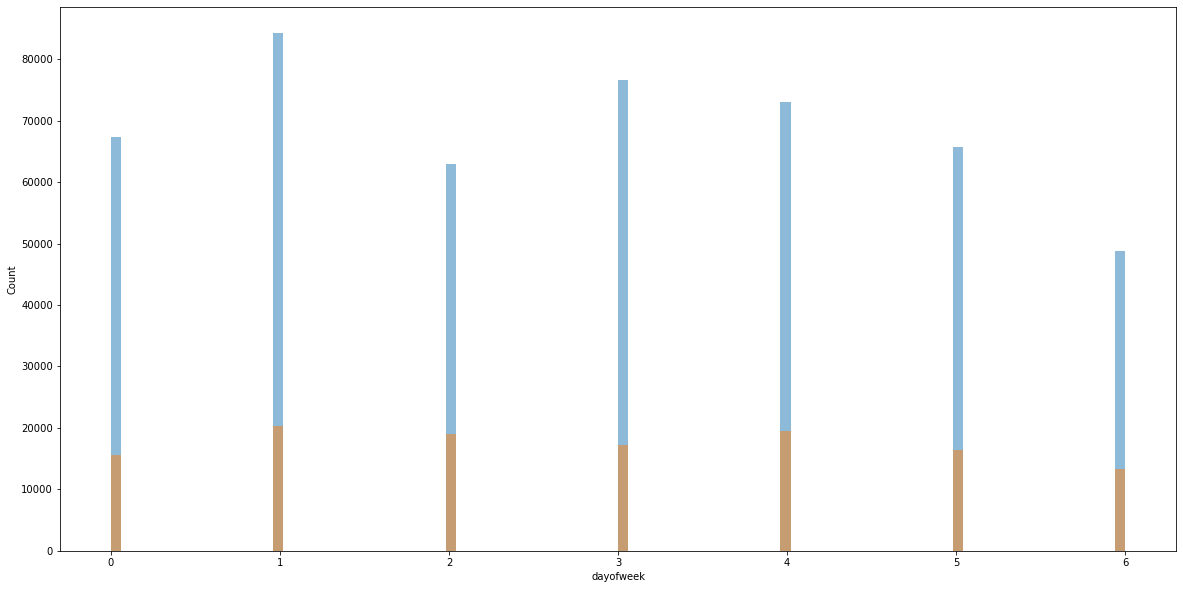

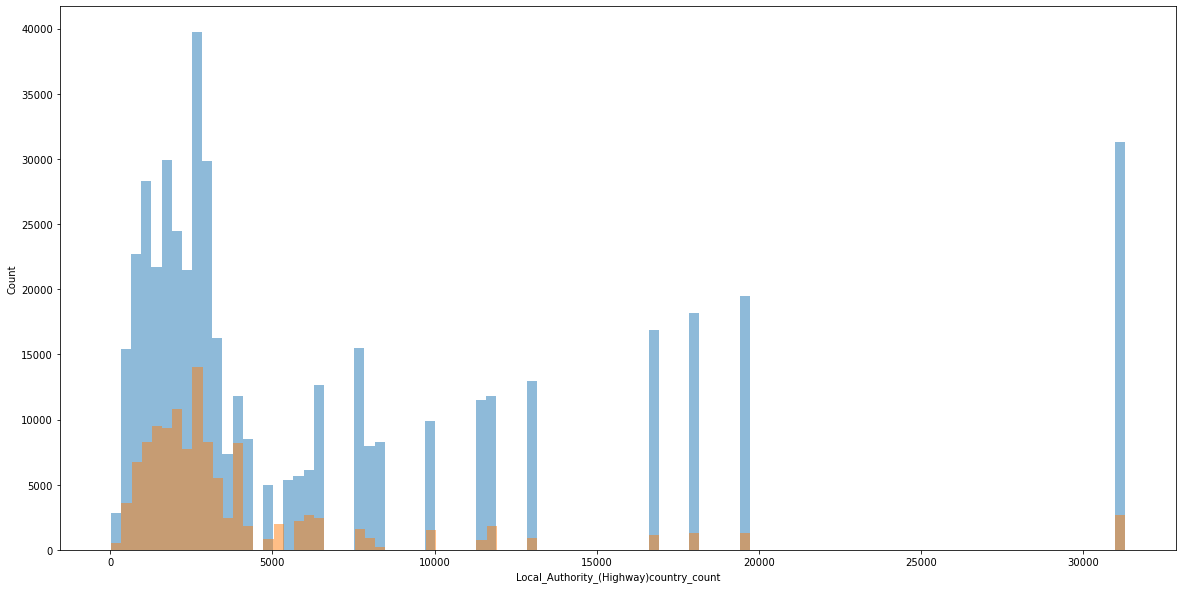

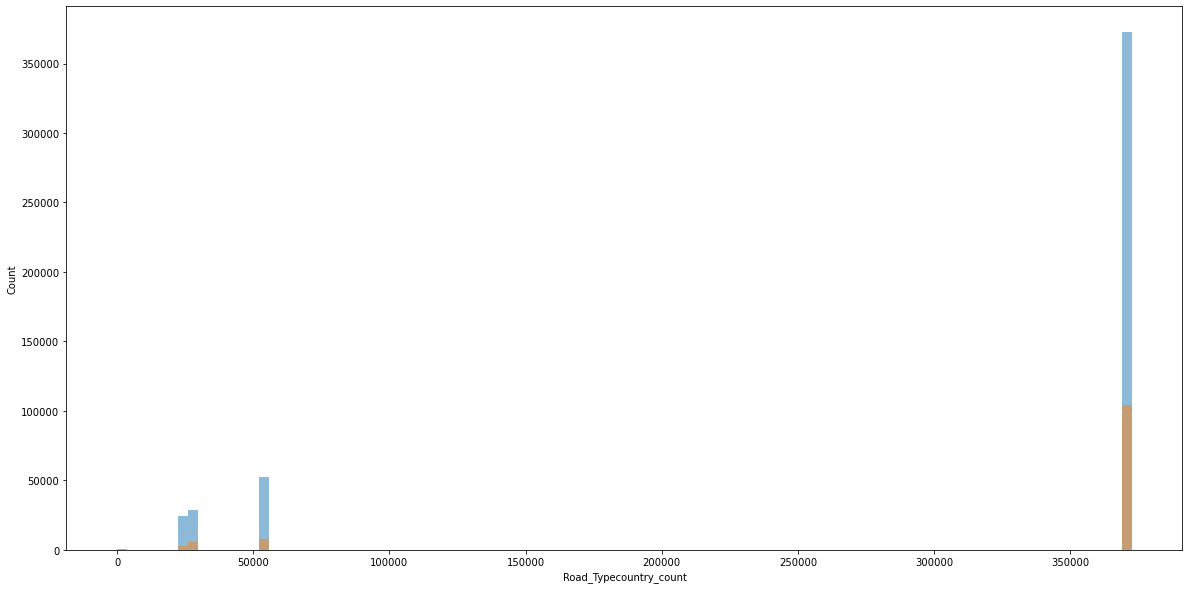

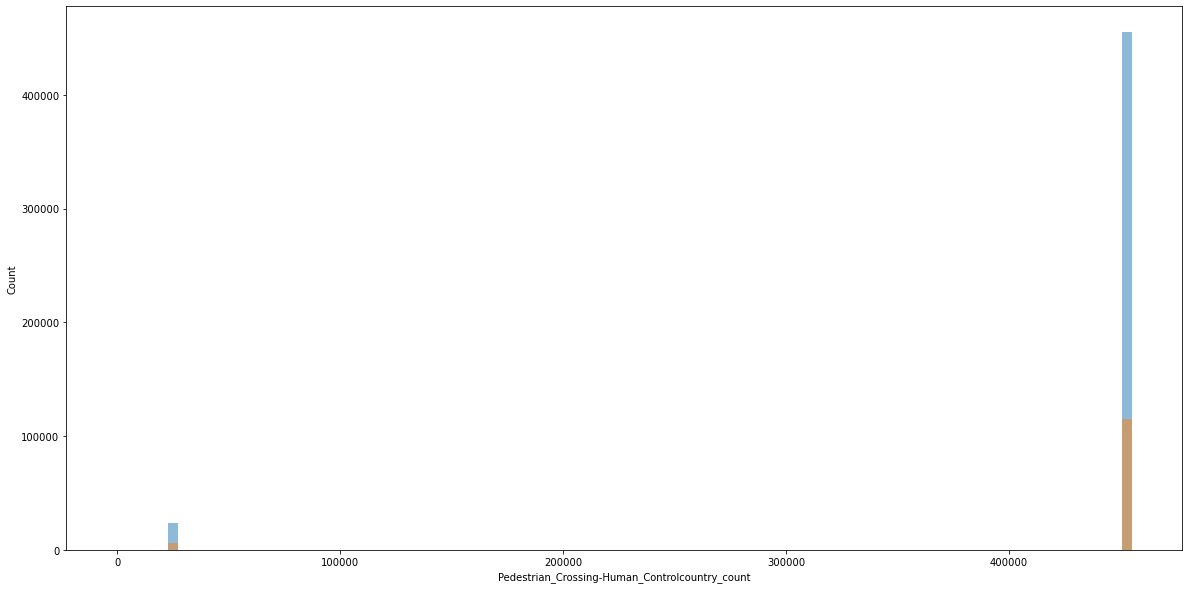

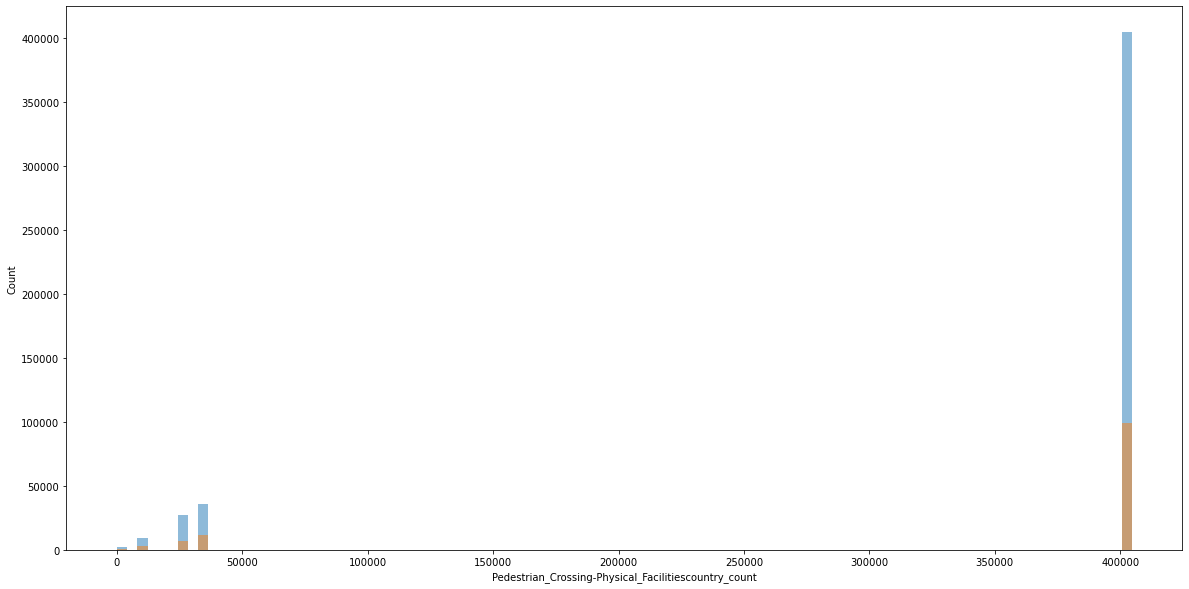

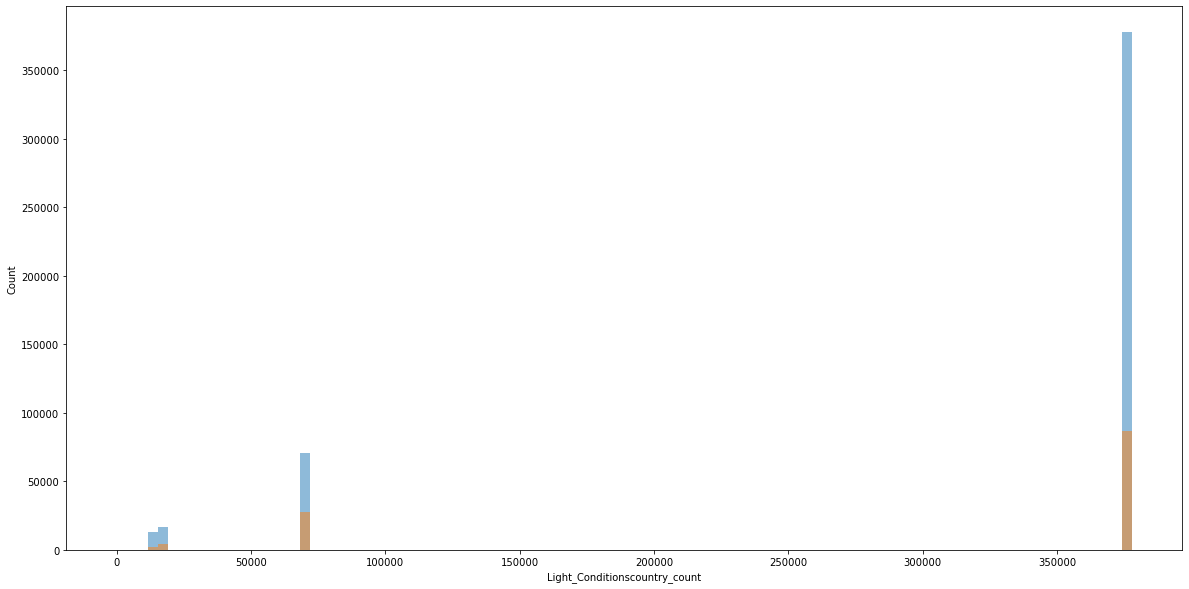

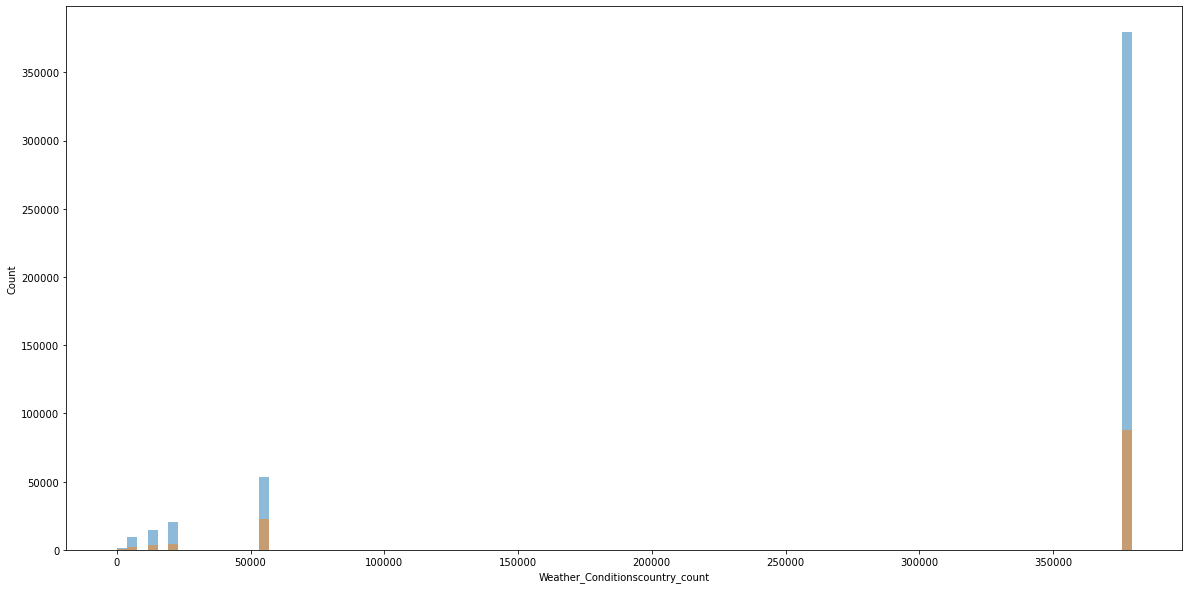

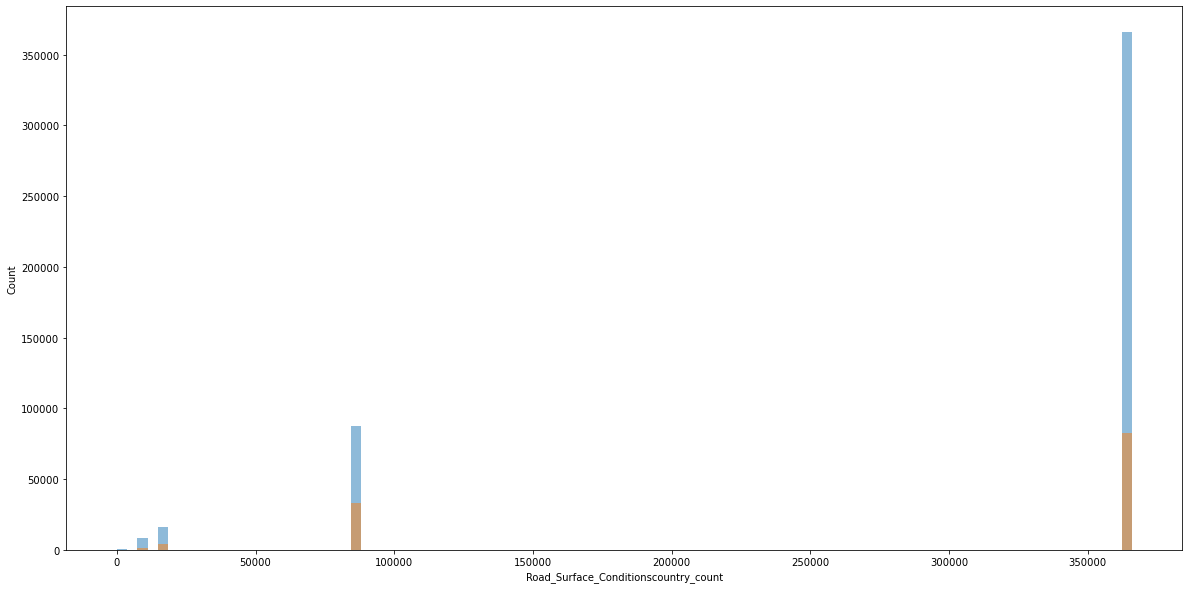

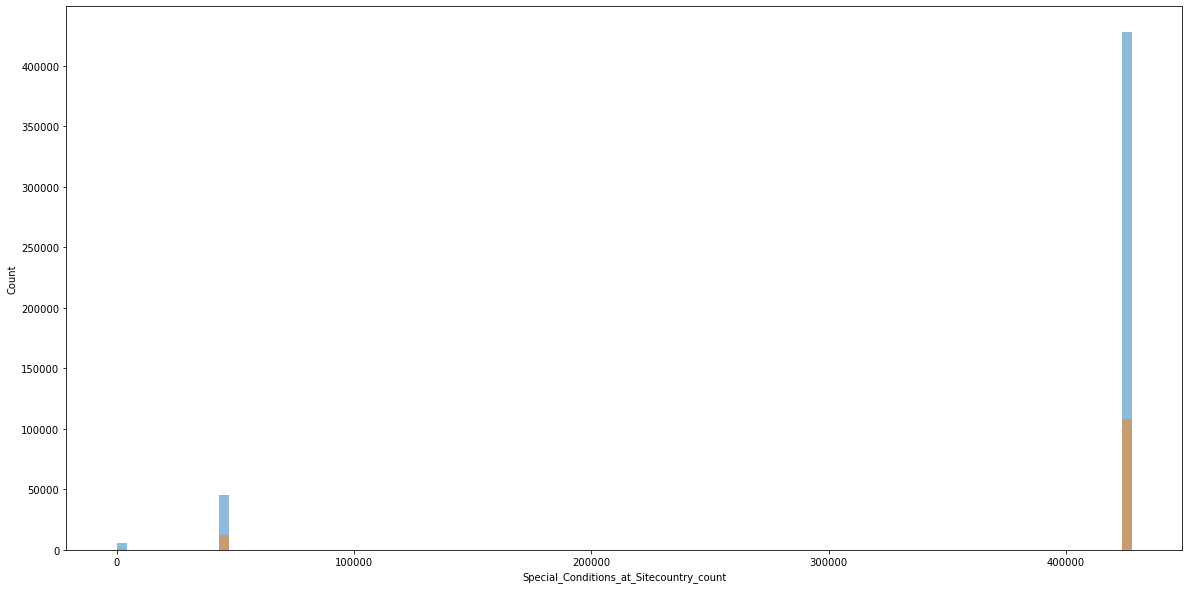

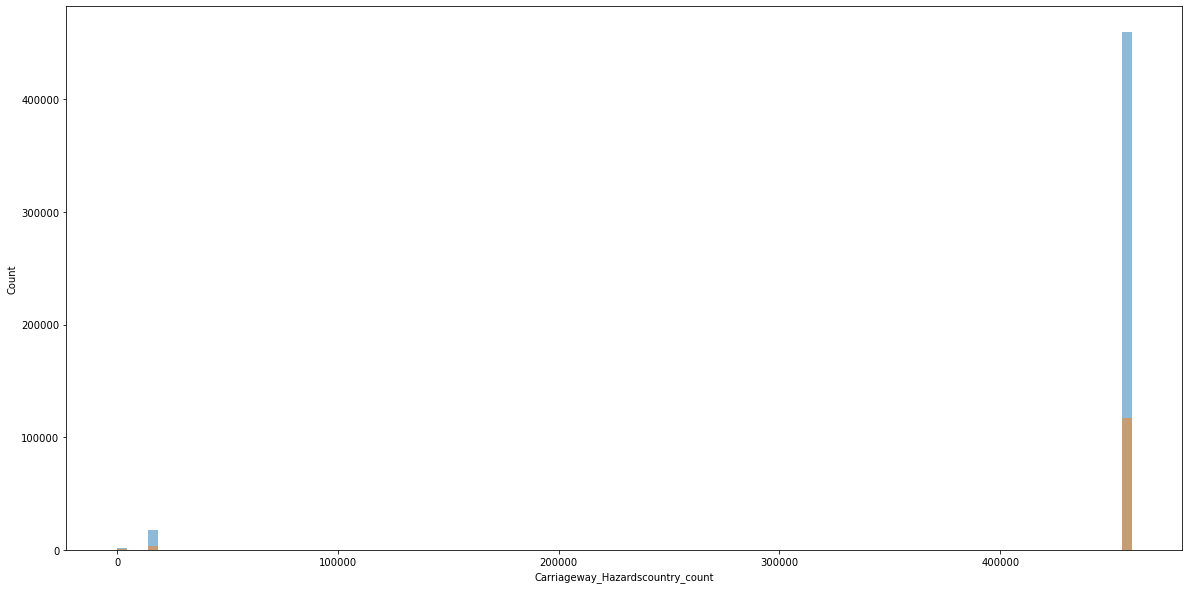

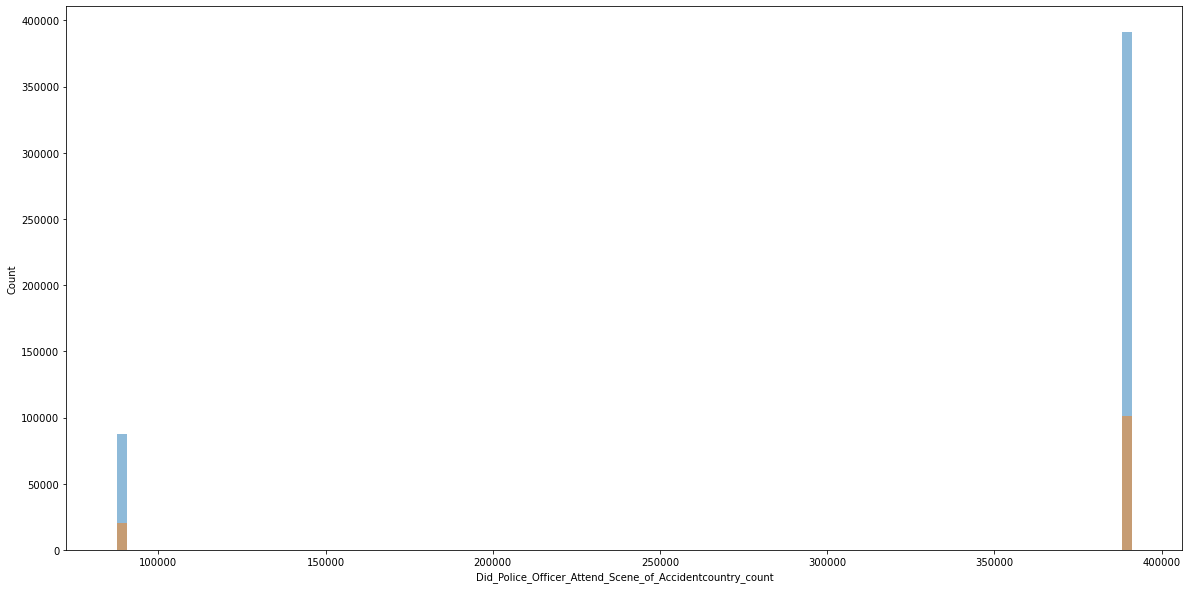

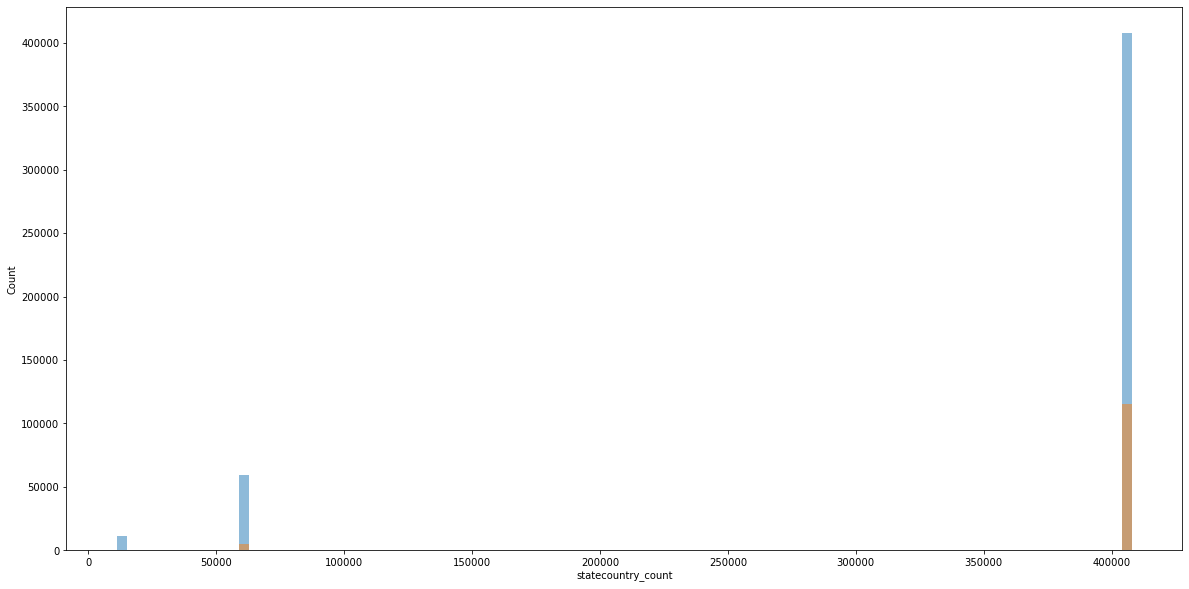

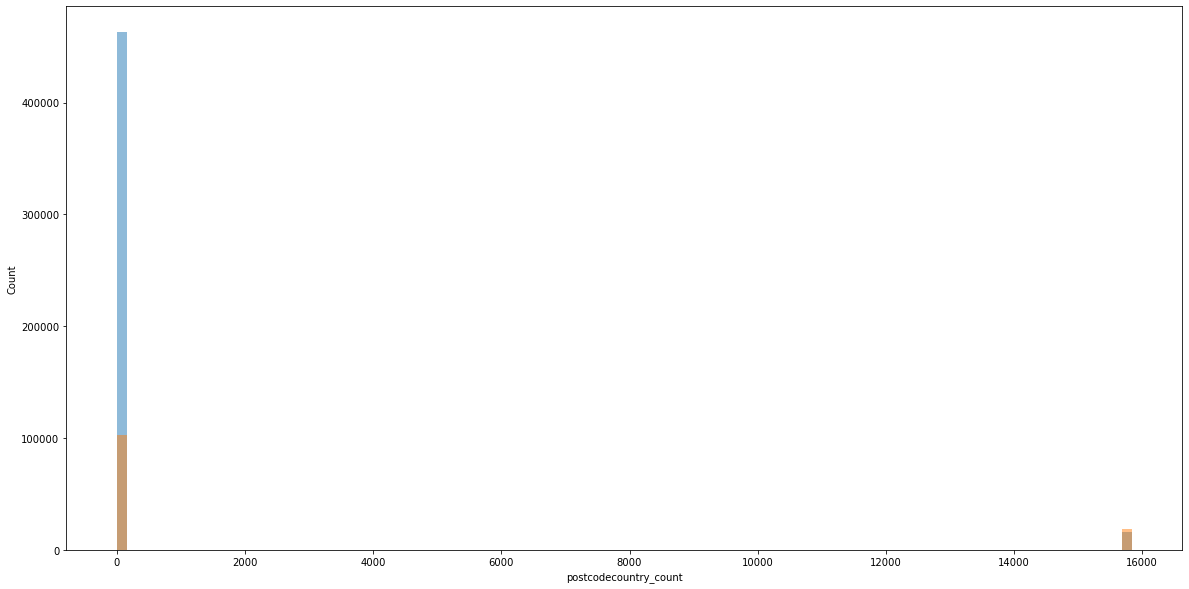

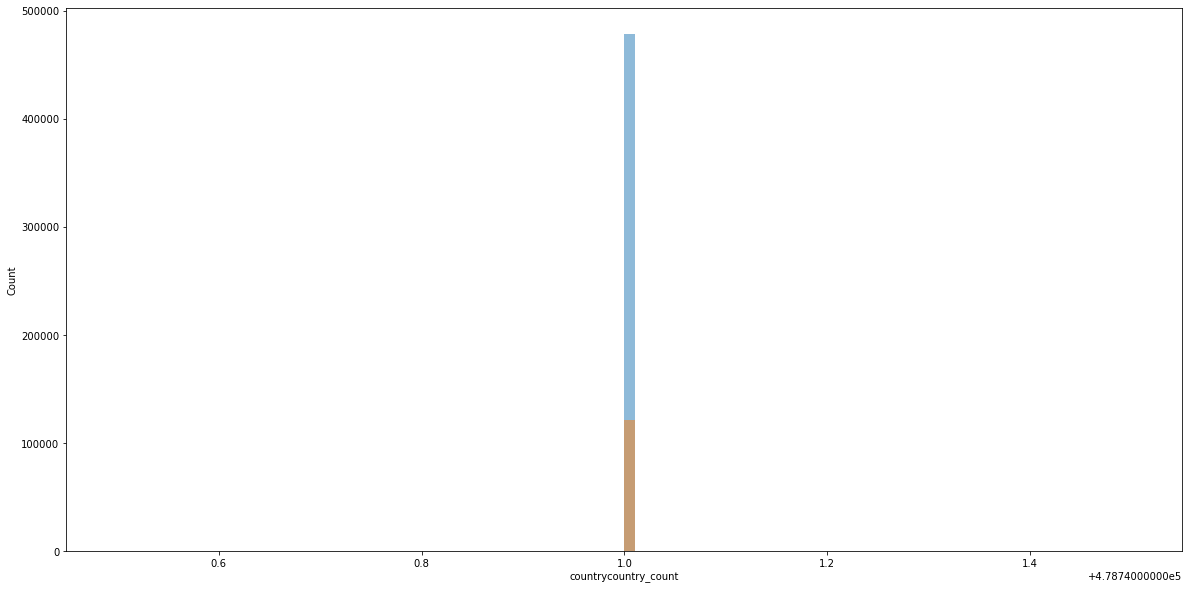

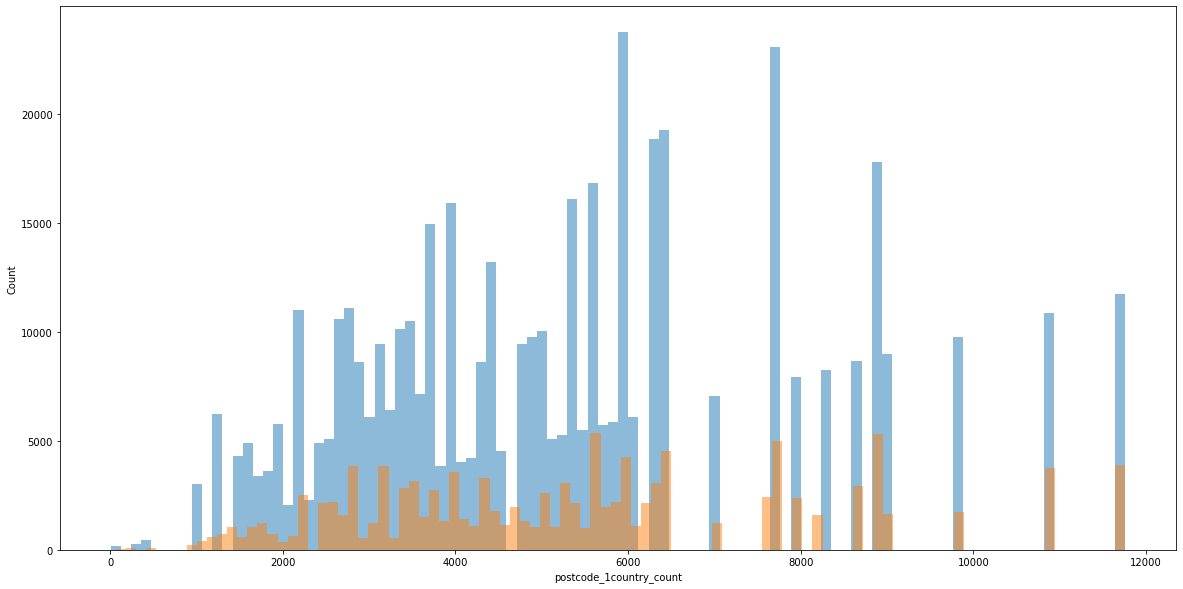

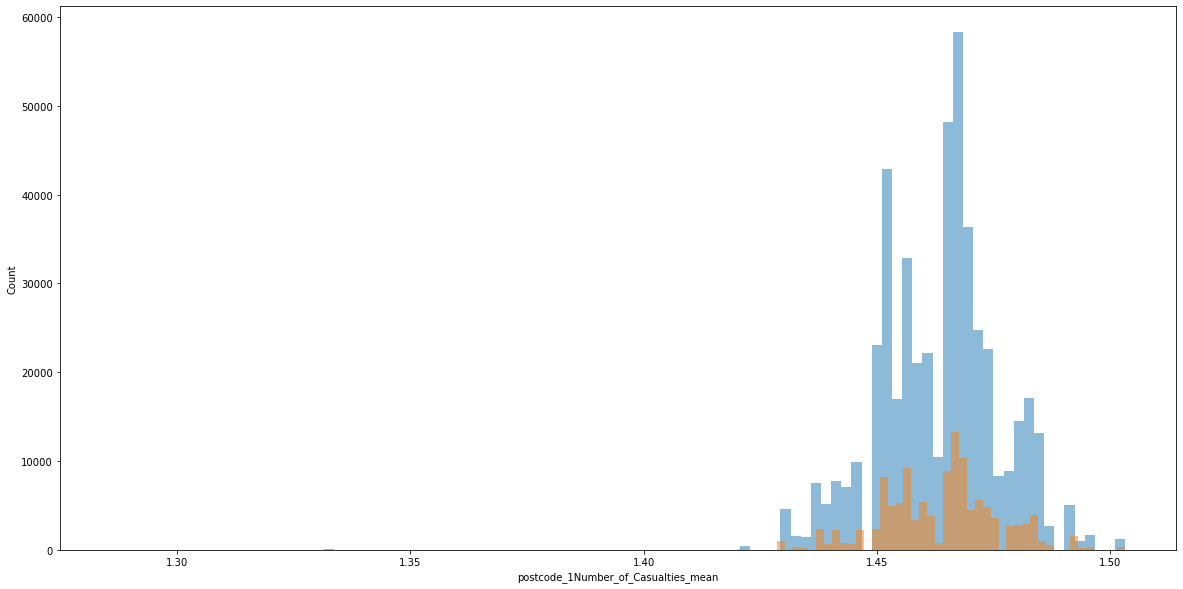

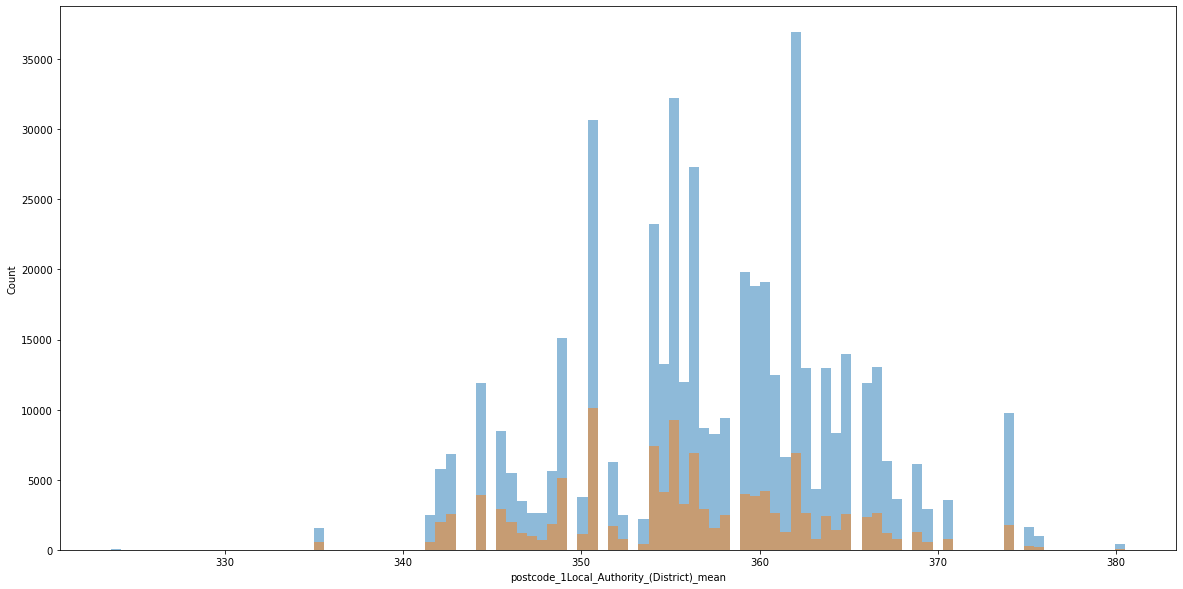

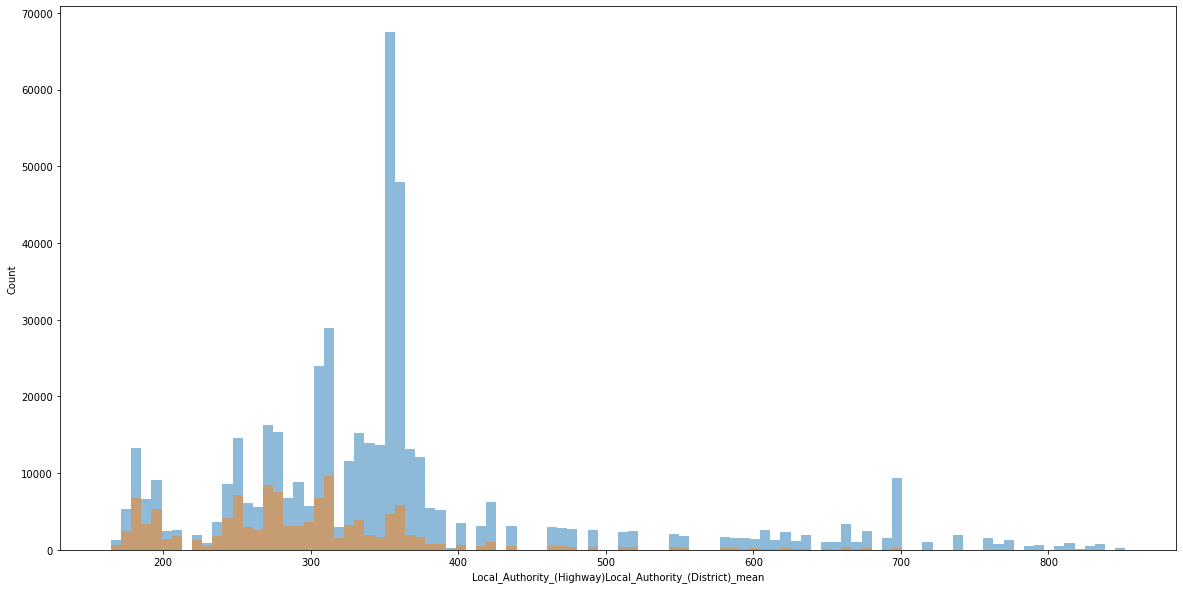

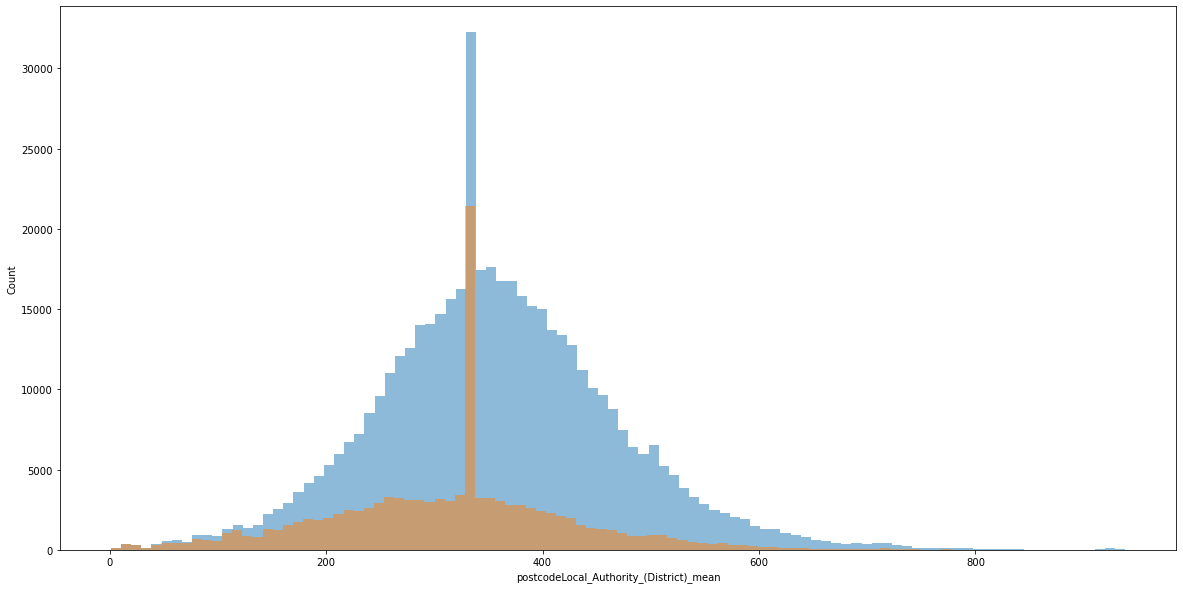

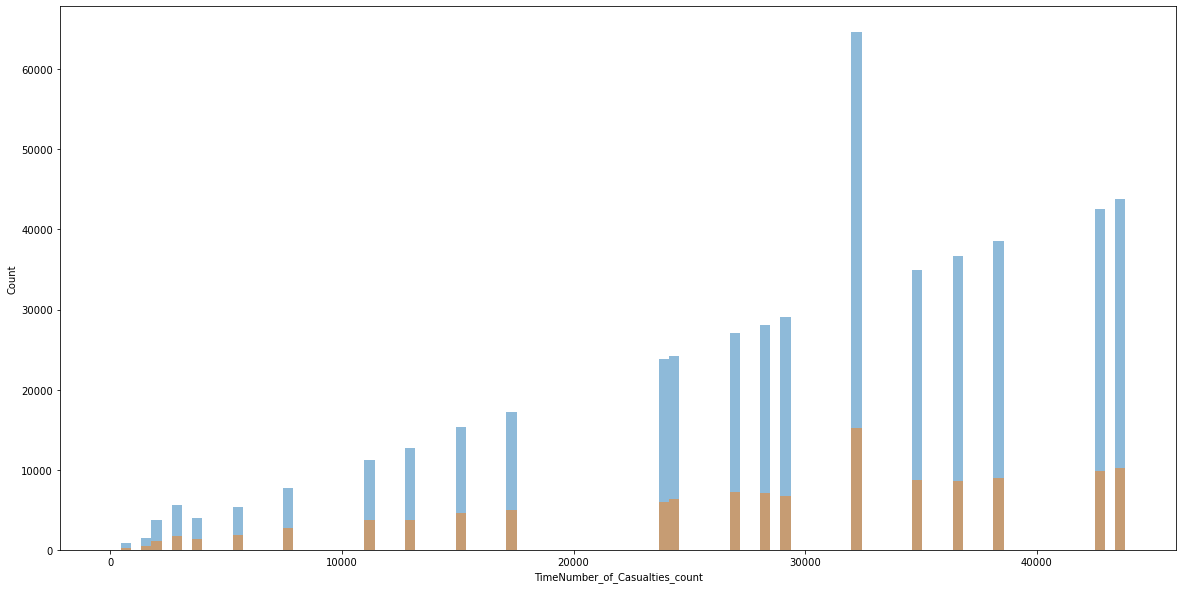

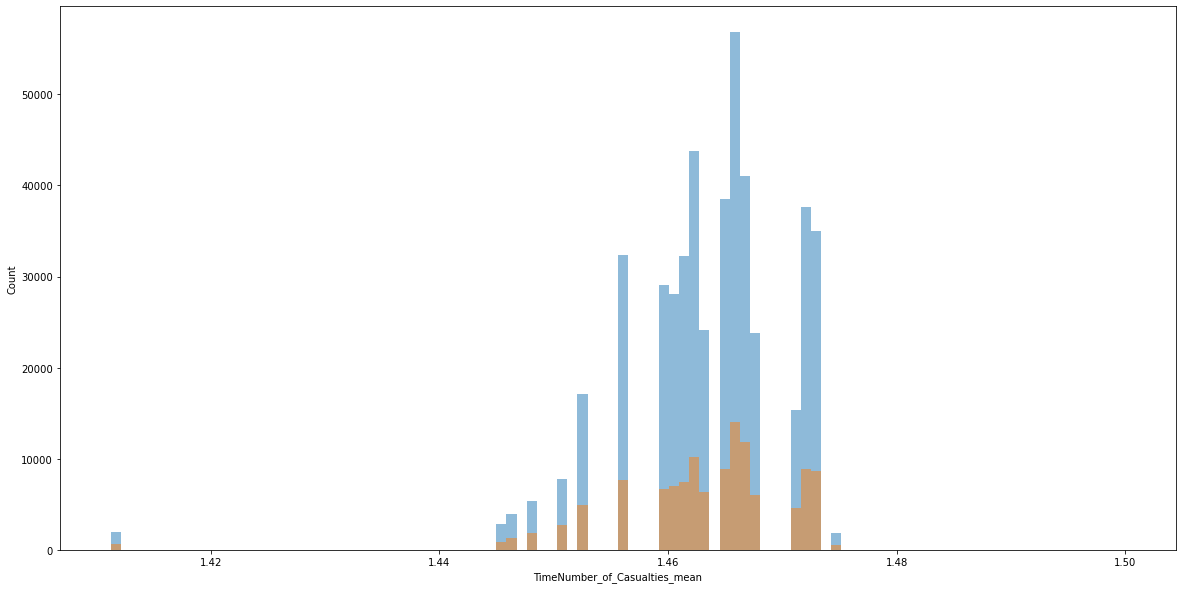

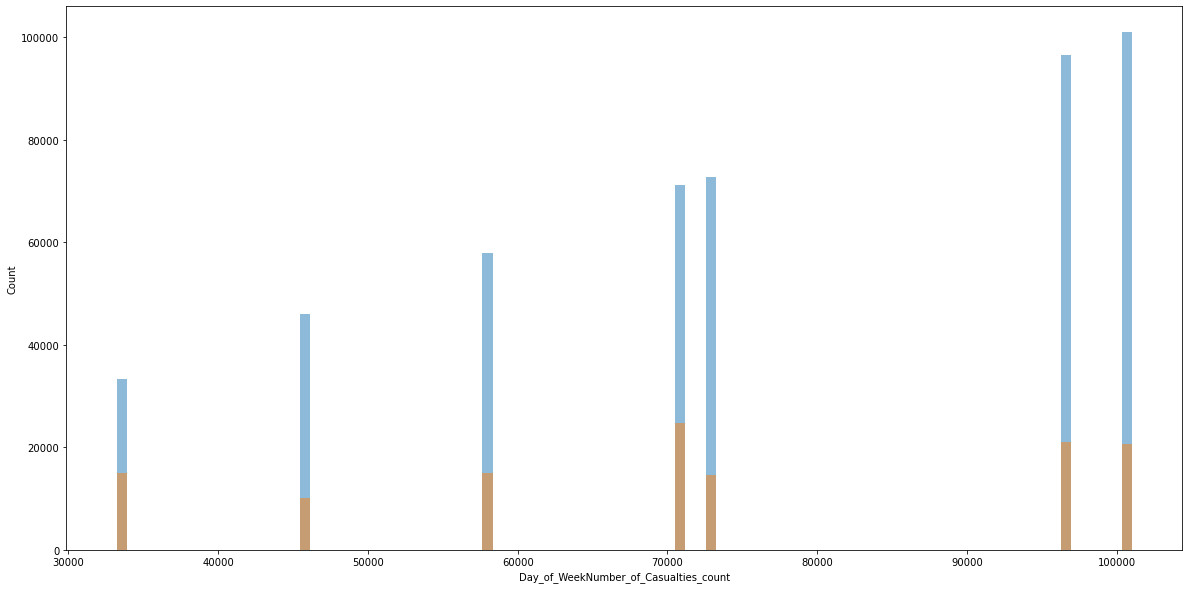

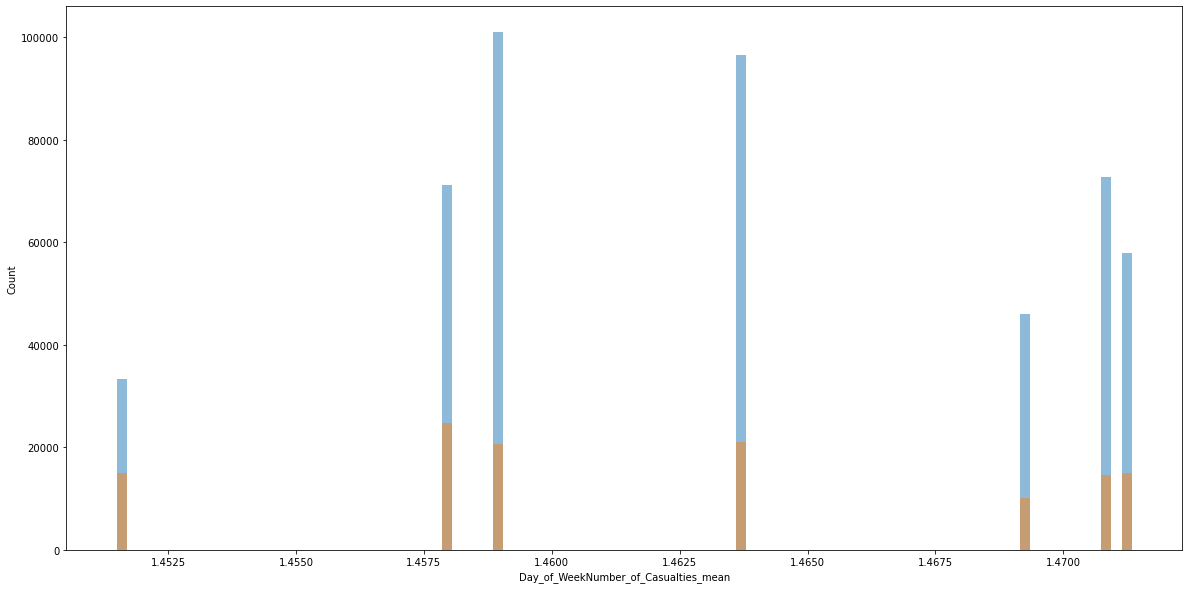

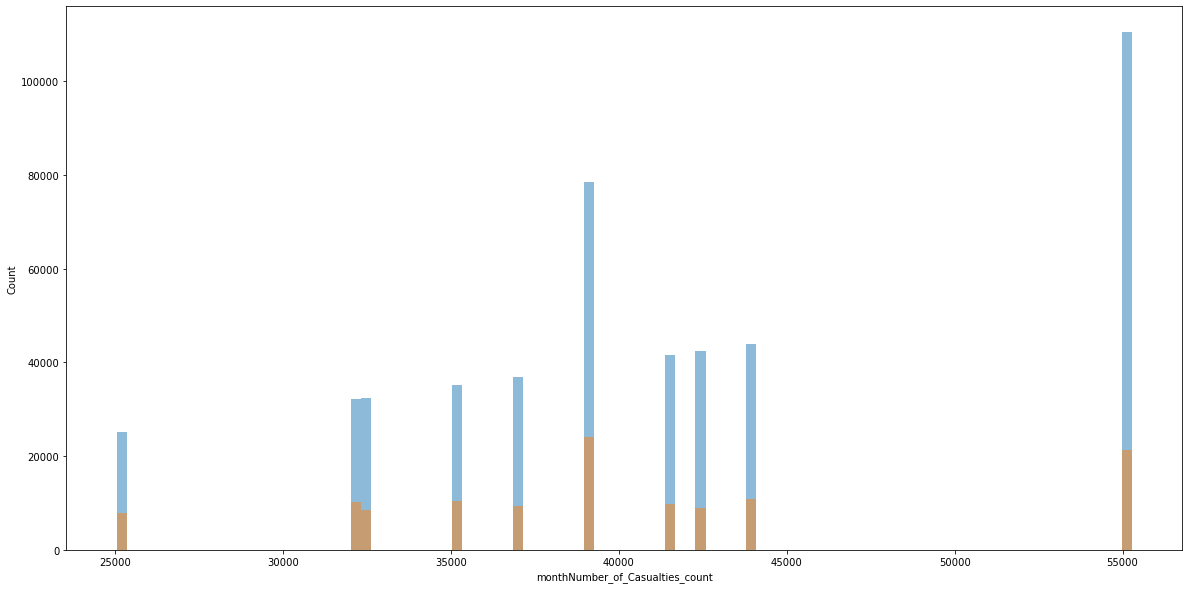

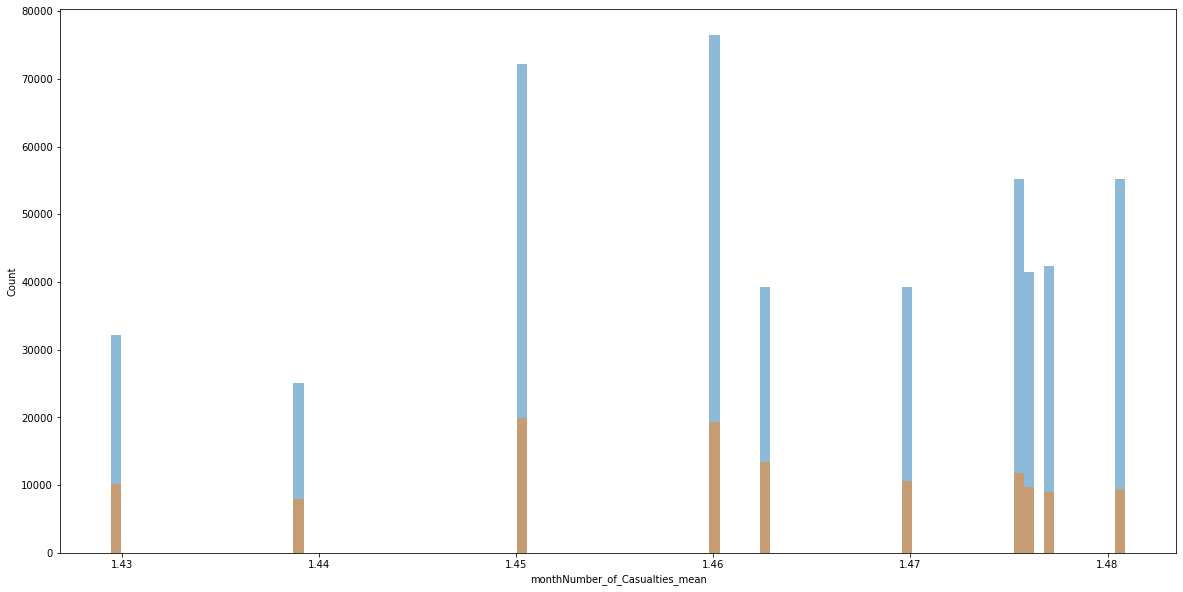

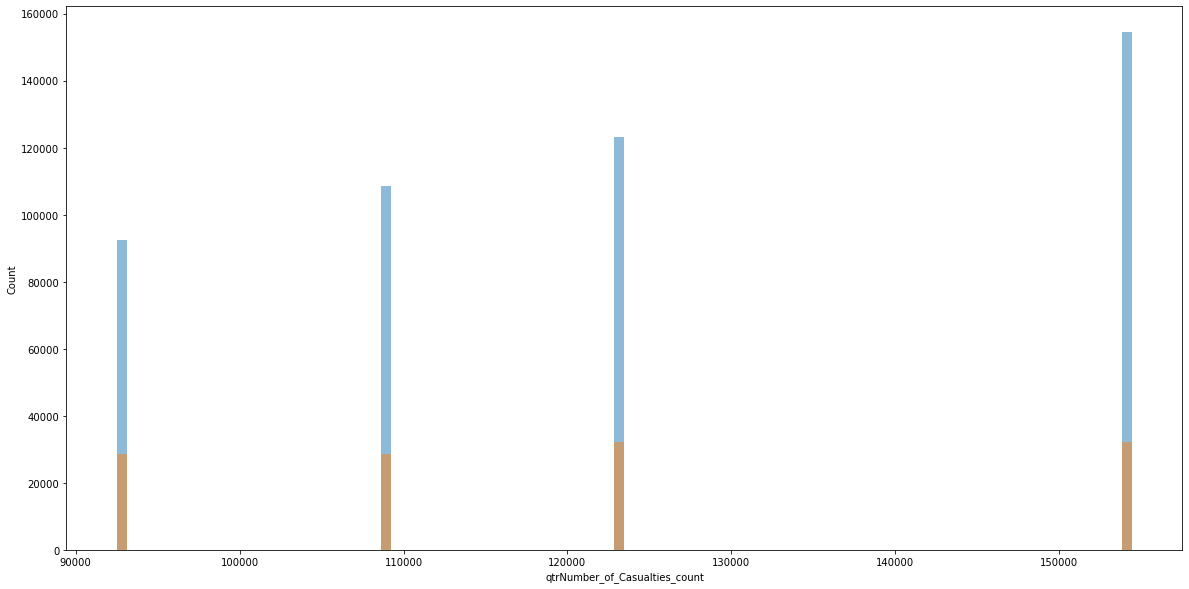

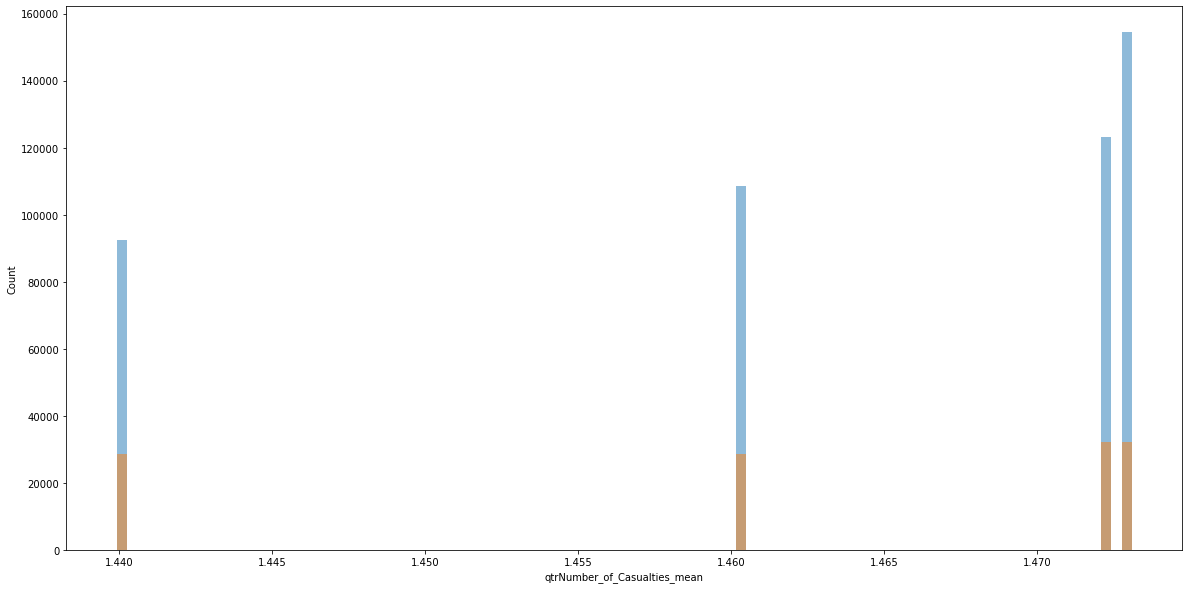

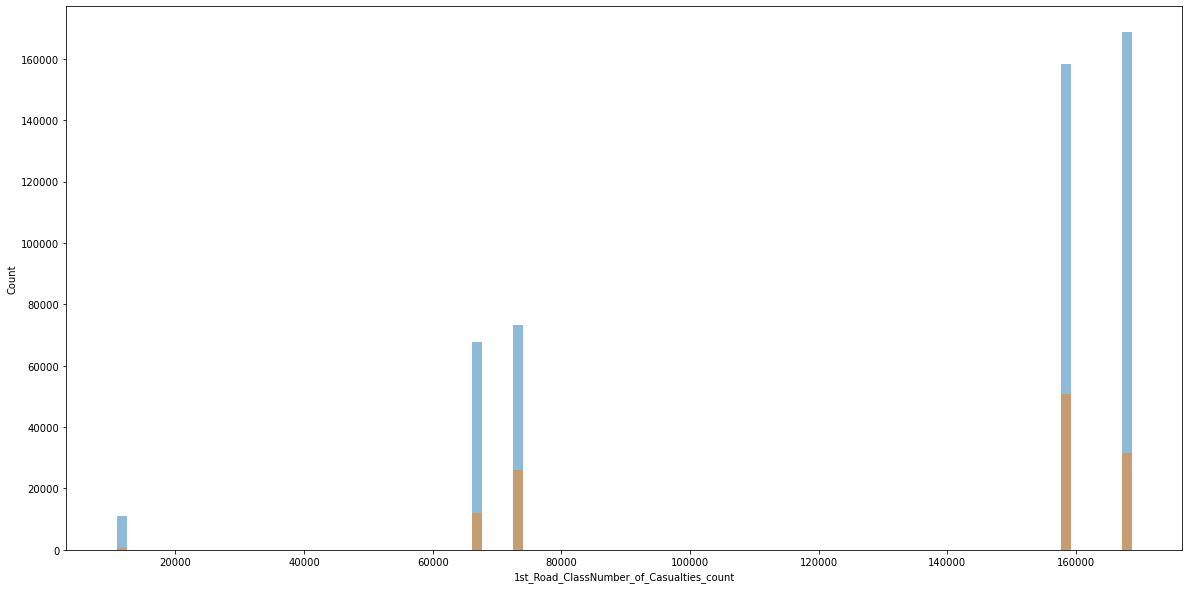

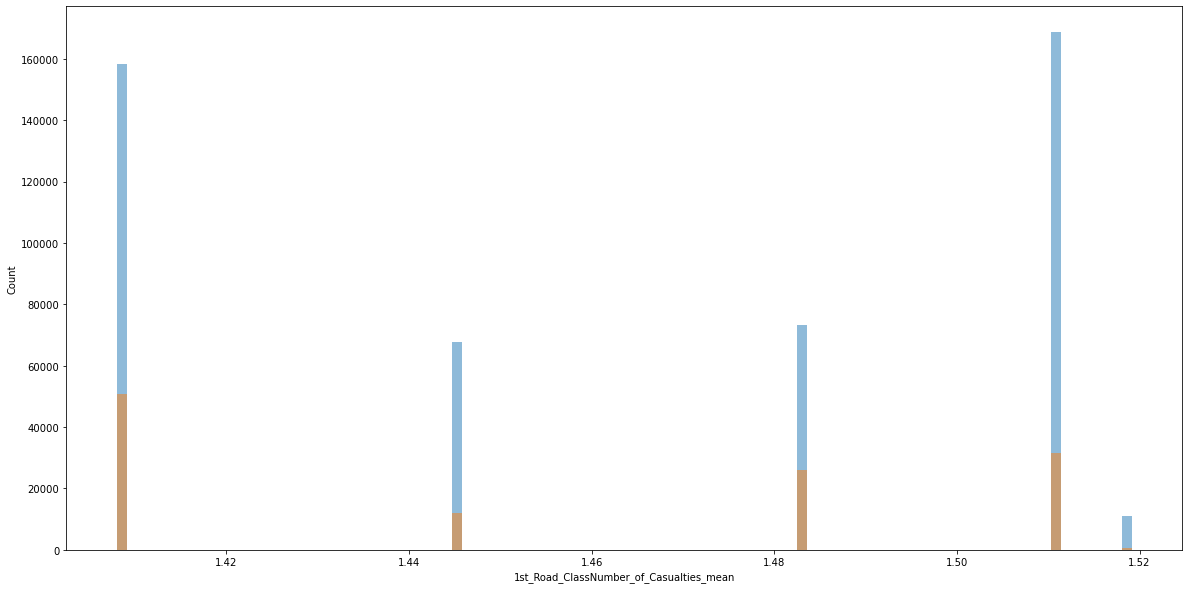

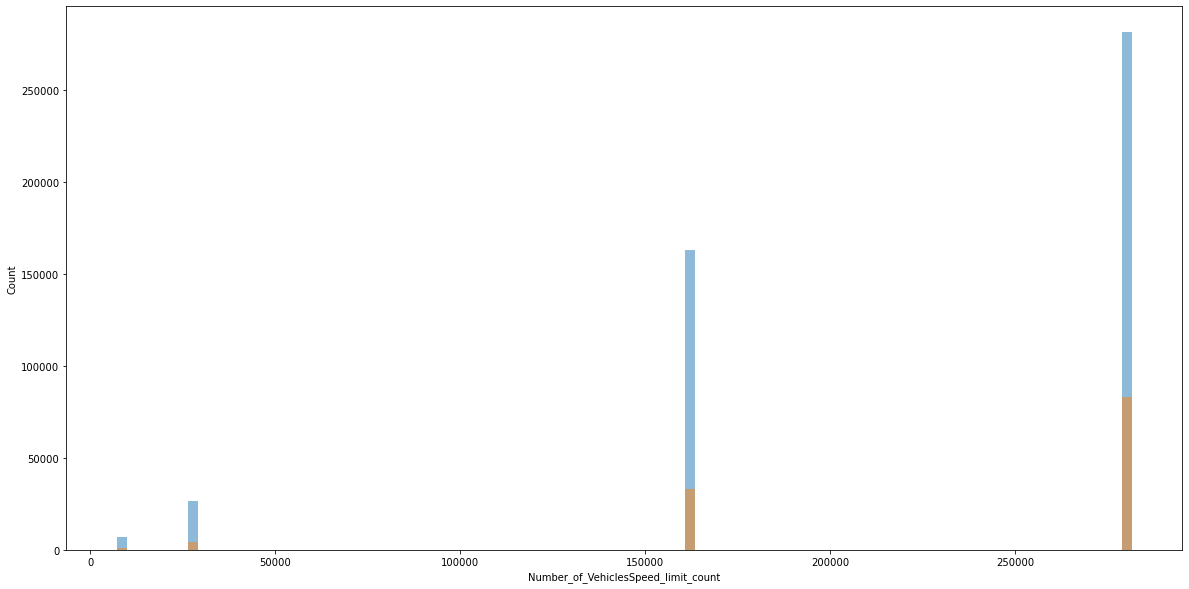

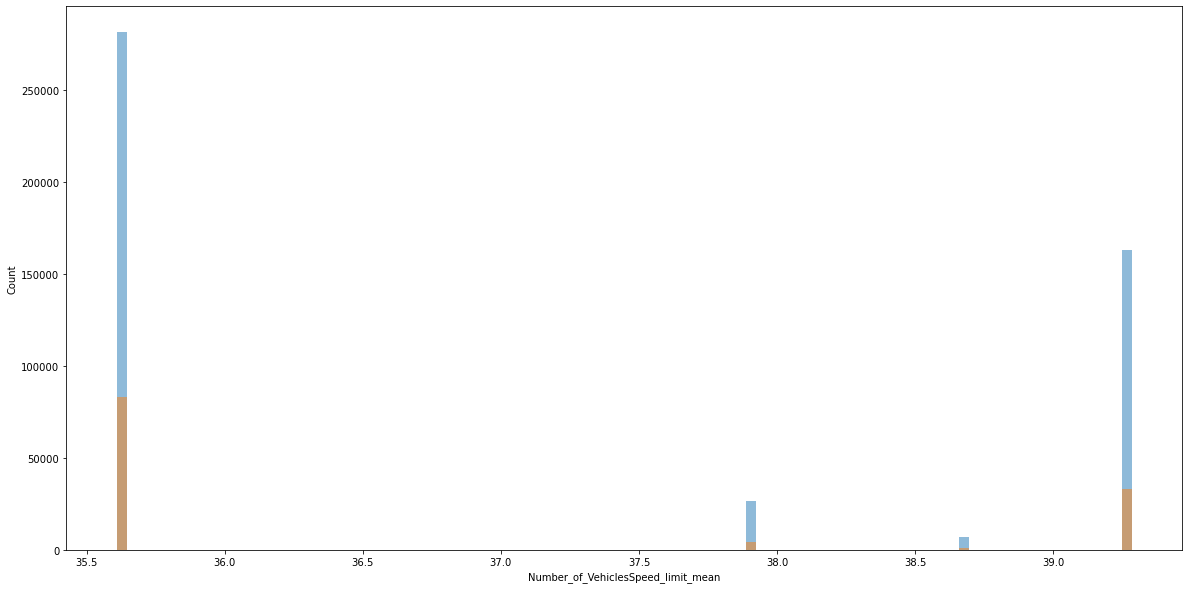

In [120]:
for col in Train.columns:
    fig, (ax1) = plt.subplots(1,1,figsize=(20, 10))
    ax1.hist(Train[col], bins=100, alpha=0.5, label=col);
    ax1.hist(Test[col], bins=100, alpha=0.5, label=col);
    ax1.set(xlabel=col, ylabel="Count")

In [121]:
#Check/Impute missing value if any : 
print(Train.columns[Train.isnull().any()])
print(Test.columns[Test.isnull().any()])

#Train.fillna(Train.mean(),inplace=True)
#Test.fillna(Test.mean(),inplace=True)

Index([], dtype='object')
Index([], dtype='object')


In [122]:
Train.head(1)

,Police_Force,Number_of_Vehicles,Day_of_Week,Local_Authority_(District),1st_Road_Class,1st_Road_Number,Speed_limit,2nd_Road_Class,Urban_or_Rural_Area,qtr,...,Day_of_WeekNumber_of_Casualties_count,Day_of_WeekNumber_of_Casualties_mean,monthNumber_of_Casualties_count,monthNumber_of_Casualties_mean,qtrNumber_of_Casualties_count,qtrNumber_of_Casualties_mean,1st_Road_ClassNumber_of_Casualties_count,1st_Road_ClassNumber_of_Casualties_mean,Number_of_VehiclesSpeed_limit_count,Number_of_VehiclesSpeed_limit_mean
0,6,2,6,76,6,403,30,-1,1,1,...,101004,1.458962,55225,1.475618,154439,1.47308,158212,1.408041,281598,35.610409


In [123]:
#Scale Features 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Train_scale    = pd.DataFrame(scaler.fit_transform(Train),columns=Train.columns)
Test_scale = pd.DataFrame(scaler.transform(Test),columns=Test.columns)

In [124]:
#Baseline Model Score Check

In [125]:
from sklearn.model_selection import cross_val_score,cross_val_predict,cross_validate

def cross_valid(model,X,Y,cv=5):
    results = cross_validate(model, X, Y,scoring="neg_mean_poisson_deviance",
                             cv=cv,return_train_score=True)
    return (results)

In [126]:
from xgboost import XGBRegressor,XGBRFRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor,StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import PoissonRegressor,TweedieRegressor,GammaRegressor


Reg_Models = [#PoissonRegressor(),
              #XGBRegressor(objective='count:poisson',
              #             use_label_encoder=False,random_state=SEED,n_jobs=-1),
              CatBoostRegressor(objective='Poisson',silent=True,
                             random_state=SEED),
              LGBMRegressor( objective='poisson',random_state=SEED,n_jobs=-1)
               ]

for i in Reg_Models:
  model = i
  error = cross_valid(model,Train_scale,Y,cv=5)
  print(error['test_score'])
  print(model,error['train_score'].mean(),error['test_score'].mean())
  print(error['train_score'].mean() - error['test_score'].mean())

[-0.35617824 -0.35897061 -0.35784142 -0.35740984 -0.35859404]
<catboost.core.CatBoostRegressor object at 0x00000149887EAD60> -0.35202427336325093 -0.3577988305008986
0.0057745571376476845
[-0.35629405 -0.35923212 -0.35818048 -0.35777282 -0.35882439]
LGBMRegressor(objective='poisson', random_state=22022022) -0.3548576653893797 -0.3580607717353592
0.003203106345979534


# Feature Selection

In [127]:
from sklearn.model_selection import StratifiedKFold,KFold,train_test_split
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm

X_train, X_test ,y_train, y_test = train_test_split(Train_scale,Y,random_state=SEED)
feature_names = list(Train.columns)
train_pool = Pool(X_train, y_train, feature_names=feature_names)
test_pool = Pool(X_test, y_test, feature_names=feature_names)

##########################
model = CatBoostRegressor(objective='Poisson',silent=True,random_state=SEED)
summary = model.select_features(
    train_pool,
    eval_set=test_pool,
    features_for_select='0-41',
    num_features_to_select=27,
    steps=1,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Exact,
    train_final_model=True,
    logging_level='Silent',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# summary

**Hyperparameter tuning did not result in any score improvement, hence used the baseline parameters instead.**

**Tried GroupKfold(On Postal Code),StratifiedKFold(On Target(Number_of_Casualties)) & Kfold as Cross validation technique. GroupKfold gave a higher score but that did not transform into better result into Leader Board. So finally went ahead with Kfold.**

In [128]:
#Selected Featuer List
sel = ['Police_Force',
  'Number_of_Vehicles',
  'Local_Authority_(District)',
  '1st_Road_Class',
  '1st_Road_Number',
  'Speed_limit',
  '2nd_Road_Class',
  'Urban_or_Rural_Area',
  'qtr',
  'Local_Authority_(Highway)country_count',
  'Road_Typecountry_count',
  'Pedestrian_Crossing-Human_Controlcountry_count',
  'Light_Conditionscountry_count',
  'Road_Surface_Conditionscountry_count',
  'Special_Conditions_at_Sitecountry_count',
  'Carriageway_Hazardscountry_count',
  'Did_Police_Officer_Attend_Scene_of_Accidentcountry_count',
  'statecountry_count',
  'postcodecountry_count',
  'postcode_1Number_of_Casualties_mean',
  'Local_Authority_(Highway)Local_Authority_(District)_mean',
  'TimeNumber_of_Casualties_mean',
  'Day_of_WeekNumber_of_Casualties_mean',
  'monthNumber_of_Casualties_mean',
  '1st_Road_ClassNumber_of_Casualties_mean',
  'Number_of_VehiclesSpeed_limit_count',
  'Number_of_VehiclesSpeed_limit_mean']

In [129]:
#Final Model Traning 
from sklearn.model_selection import cross_validate

clf= CatBoostRegressor(objective='Poisson',silent=True,
                                random_state=SEED)

output = cross_validate(clf,Train_scale[sel],Y, cv=3, scoring = 'neg_mean_squared_error',
                        return_estimator=True,return_train_score=True)


In [130]:
print(output['train_score'].mean())
print(output['test_score'].mean())

-0.6453550136801205
-0.6548199331116423


In [131]:
feature_importances_avg = [] 

for idx,estimator in enumerate(output['estimator']):
    #print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = estimator.feature_importances_
    feature_importances_avg.append(feature_importances)
    
feature_importances = np.mean(feature_importances_avg,0)
feature_importances = pd.DataFrame(np.mean(feature_importances_avg,0) , 
                     index = Train_scale[sel].columns, columns=['importance']).sort_values('importance', ascending=False)

feature_importances.head(50)

,importance
Police_Force,18.837826
Local_Authority_(District),14.004176
1st_Road_Number,9.530448
Local_Authority_(Highway)country_count,5.280531
postcode_1Number_of_Casualties_mean,5.184842
Speed_limit,5.134886
Local_Authority_(Highway)Local_Authority_(District)_mean,5.086050
postcodecountry_count,3.835815
TimeNumber_of_Casualties_mean,2.823344
1st_Road_ClassNumber_of_Casualties_mean,2.749164


In [132]:
#Test Set Predection 

sub_file = []

for idx,estimator in enumerate(output['estimator']):
    print(idx)
    score = estimator.predict(Test_scale[sel])
    sub_file.append(score)
    
final = np.mean(sub_file,0)

0
1
2


In [133]:
#Prepare Final Submission file : 
Test_sub = pd.read_csv('test.csv')
Test_sub['Accident_risk_index'] = final
#
Target_mapper =  Test_sub.groupby(['postcode'])['Accident_risk_index'].mean()
#
SampleSubmission['Accident_risk_index'] = SampleSubmission['postcode'].map(Target_mapper)
#
SampleSubmission['Accident_risk_index'].std(),SampleSubmission.tail()
#
SampleSubmission.to_csv('26M.csv',index=False)